<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/> 

# TSO JWebbinar Notebook 1: Downloading and Calibrating `uncal` TSO Products
-----

**Author**: Néstor Espinoza | AURA Assistant Astronomer | Mission Scientist for Exoplanet Science
<br>
**Last Updated**: December 1st, 2023
<br>
**Pipeline Version**: 1.12.5

## Table of contents
1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Data & Context of the Observations](#data)<br>
2. [Downloading & Quick Looks at JWST TSO data](#download)<br>
   2.1 [Downloading TSO data from MAST](#mast)<br>
   2.2 [Quicklook, pt. I: Target Acquisition](#ta)<br>
   2.3 [Quicklook, pt. II: `datamodels` & TSO Science Data Products](#science)<br>
4. [A TSO tour through the `Detector1` stage](#detector1)<br>
   3.1 [Checking data quality flags](#dqflags)<br>
   3.2 [Identifying saturated pixels](#saturation)<br>
   3.3 [Removing detector-level effects: the `superbias` and `refpix` steps](#refpix)<br>
   3.4 [Linearity corrections](#linearity)<br>
   3.5 [Removing the dark current](#darkcurrent)<br>
   3.6 [Handling 1/f noise at the group-level](#1overf)<br>
   3.7 [Detecting "jumps" on up-the-ramp sampling](#jump)<br>
   3.8 [Fitting ramps with the `ramp_fit` step](#rampfit)<br>
6. [Final words](#final-words)<br>

---

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

### 1.1<font color='white'>-</font>Purpose of this Notebook<a class="anchor" id="purpose"></a> ###

In this Notebook, we aim to perform an exploration of Time Series Observations (TSO) products, focusing in particular on products obtained by the [Transiting Exoplanet JWST Early Release Science (ERS) team](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366) --- a real science dataset that we will reduce starting from the most "raw" forms of data products that can be downloaded from MAST. We will learn how to download those products, as well as how to load them and make them interact with the JWST Calibration Pipeline to calibrate them. In a companion Notebook, we then perform spectroscopic analyses on this dataset.

### 1.2<font color='white'>-</font>Data & Context of the Observations<a class="anchor" id="data"></a> ###

The input data for this Notebook are observations from the Transiting Exoplanet ERS team; in particular, observations of the exoplanet WASP-39b obtained with the JWST NIRSpec/G395H mode. This mode stores data in two detectors, NRS1 and NRS2 which hold data from about 3-4 $\mu$m and 4-5 $\mu$m, respectively. Results from those observations were presented in [Alderson et al. (2023)](https://www.nature.com/articles/s41586-022-05591-3), and consist of the transmission spectrum of the exoplanet in the 3-5 $\mu$m range. This is a couple-of-hundred integrations, 70-group dataset.

To get started, let's load some libraries that we will use in the following notebook:

In [1]:
# Need to set these enviromental variables for this notebook to work properly:
%set_env CRDS_PATH $HOME/crds_cache
%set_env CRDS_SERVER_URL https://jwst-crds.stsci.edu

# Import standard python libraries:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Import a 2D median filter:
from scipy.signal import medfilt2d

# Import Observations from astroquery.mast to perform data downloads:
from astroquery.mast import Observations

# Import some JWST Calibration pipieline libraries we will use to load and calibrate our data:
import jwst
from jwst import datamodels
from jwst.pipeline import calwebb_detector1

env: CRDS_PATH=$HOME/crds_cache
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


Check pipeline version we will be using:

In [2]:
jwst.__version__

'1.12.5'

<div class="alert alert-block alert-info"> <b>Notes on the validity of this notebook</b>: It is important to realize that this notebook, as it is, is likely to be quickly outdated as new algorithms and fixes are implemented into the JWST Calibration pipeline, as well as new methodologies and studies update our knowledge of optimally calibrating JWST data products. An up-to-date list of known JWST pipeline issues (some of which we touch on this notebook) can be found on the <a href="https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/known-issues-with-jwst-data-products">Known Issues with the JWST Data Products</a> JDox page. In doubt, or for any questions, please contact <a href="https://jwst-docs.stsci.edu/jwst-help-desk">the JWST Helpdesk</a>!

2.<font color='white'>-</font>Downloading & Quick Looks at JWST TSO data <a class="anchor" id="download"></a>
------------------

The very first step when it comes to analyzing a JWST dataset is to download that data and perform some quick looks so we know the data quality is acceptable to begin with. Here, we will download the `uncal` products, which are one of the "raw"-est forms of dataproducts users can download from MAST. We will perform our data download from MAST using `astroquery.mast` and then use the JWST Calibration pipeline to read and have quicklooks at this data. Let's begin!

### 2.1<font color='white'>-</font>Downloading TSO data from MAST<a class="anchor" id="mast"></a> ###

To download JWST data from MAST, we will use the `Observations` function from the `astroquery.mast` library. To do this, we need to indicate the properties of the dataset of interest. For this we need to figure out what instrument, filter, program ID _and_ target was obseved. Options for JWST TSO instruments are `NIRISS/SOSS`, `NIRSPEC/SLIT`, `NIRCAM/GRISM`, `MIRI/SLITLESS`, `NIRSPEC/SLIT`, etc. Here, we search for `NIRSpec/SLIT`, and the `F290LP;G395H` filter/grating combination, which corresponds to the dataset we want. We define the proposal ID for the ERS program (`1366`) and the name of the target, `WASP-39`:

In [3]:
download = False

observation = Observations.query_criteria(instrument_name = 'NIRSpec/SLIT', 
                                          filters='F290LP;G395H', 
                                          proposal_id = '1366', 
                                          target_name = 'WASP-39')

This saves _all_ possible observations in the `observation` variable. Then, we filter all the products to get only the `SCIENCE`, `UNCAL` data products:

In [4]:
# Get data products:
data_products = Observations.get_product_list(observation)

# Filter them to get ramps and rateints; only for the fourth segment of data:
uncals = Observations.filter_products(data_products, productType = 'SCIENCE', productSubGroupDescription = 'UNCAL')

Let's check these observations out:

In [5]:
uncals

<Table masked=True length=8>
 obsID   obs_collection dataproduct_type ... dataRights calib_level
  str8        str4            str8       ...    str6       int64   
-------- -------------- ---------------- ... ---------- -----------
87768927           JWST            image ...     PUBLIC           1
87768928           JWST            image ...     PUBLIC           1
87769343           JWST            image ...     PUBLIC           1
87769340           JWST            image ...     PUBLIC           1
87769345           JWST            image ...     PUBLIC           1
87769342           JWST            image ...     PUBLIC           1
87769341           JWST            image ...     PUBLIC           1
87769344           JWST            image ...     PUBLIC           1

Note how there are 8 data products. The first 2, which have the lowest `size` values are the Target Aquisition exposures, used to lock the data into place. These are _very_ useful to check the quality of the observations (and whether or not they were successful!). The _actual_ TSO data are all the products that follow. Note the latter data are segmented --- this is done in the ground to facilitate the processing of the data. Also note, for the TSO products, there are 3 segments of data per detector (`nrs1` and `nrs2`).

Let's download all the data, including the Target Acquisition frames, which might be useful to diagnose the quality of observations:

In [6]:
if download:
    
    Observations.download_products(uncals)

Great, all downloads are complete! Let's perform some quick looks at those datasets, which we can do right away without the need to actually calibrate our data products.

### 2.2<font color='white'>-</font>Quicklook, pt. I: Target Acquisition<a class="anchor" id="ta"></a> ###

The first set of data products we will have a look at are the Target Acquisition (TA) frames. These are frames that are used to precisely center objects in JWST, so as to correct from any JWST blind pointing errors. These frames are taken before the optical element that disperses the light for our TSO observations is put into place, and before doing any small slews to the actual science targets (which should be in the worst case scenario a few tens of arcseconds away from the science target).

Note there are two TA frames. [This is expected](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-target-acquisition/nirspec-wide-aperture-target-acquisition); the usual TA WATA procedure (which is used for TSOs) has one exposure that is used to correct for any pointing errors, and a post-correction TA, which is taken as a "confirmation" exposure. We can load those frames with the JWST `datamodels`, which as we will see below are extremely useful models to deal with JWST data, as follows: 

In [7]:
ta1 = datamodels.RampModel('mastDownload/JWST/jw01366003001_02101_00001-seg001_nrs1/jw01366003001_02101_00001-seg001_nrs1_uncal.fits')
ta2 = datamodels.RampModel('mastDownload/JWST/jw01366003001_02101_00002-seg001_nrs1/jw01366003001_02101_00002-seg001_nrs1_uncal.fits')

The `data` attribute of those `datamodels` (e.g., `ta1.data`) stores the actual data from those frames. Let's check the dimensions of those first to familiarize ourselves with those data products:

In [8]:
print('Dimensions of the first TA frame: ', ta1.shape)
print('Dimensions of the second TA frame: ', ta2.shape)

Dimensions of the first TA frame:  (1, 3, 32, 32)
Dimensions of the second TA frame:  (1, 3, 32, 32)


The dimensions come in the form `(integrations, groups, pixel, pixel)` --- so both are 1-integration exposures, of 3 groups each, on a 32x32 pixel frame. This actually is exactly what is expected from WATA TA frames!

Let's take a look at the last group of the first TA frame:

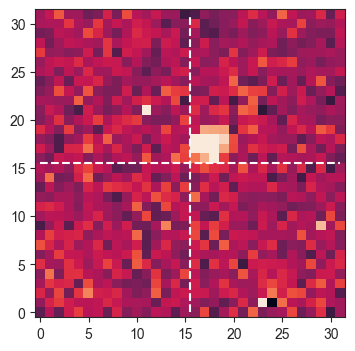

In [9]:
plt.figure(figsize=(4,4))

im = plt.imshow(ta1.data[0, -1, :, :], aspect = 'auto', origin = 'lower', interpolation = None)

plt.plot([0,31], [31./2., 31./2.], '--', color = 'white')
plt.plot([31./2., 31./2.], [0,31], '--', color = 'white')

im.set_clim(3000,10000)

Nice! There is a source, although it appears slightly off-center, it is reasonably placed around the center of the frame. Let's take a look at the second one:

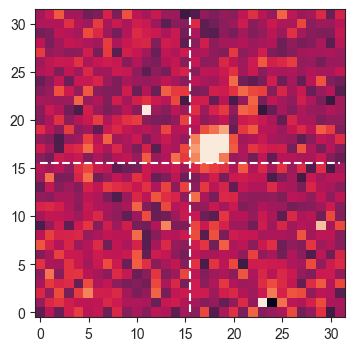

In [10]:
plt.figure(figsize=(4,4))

im = plt.imshow(ta2.data[0, -1, :, :], aspect = 'auto', origin = 'lower', interpolation = None)

plt.plot([0,31], [31./2., 31./2.], '--', color = 'white')
plt.plot([31./2., 31./2.], [0,31], '--', color = 'white')

im.set_clim(3000,10000)

Same story. It seems, overall, the TA was fairly successful. Let's move to check the science data next!

### 2.3<font color='white'>-</font>Quicklook, pt. II: `datamodels` & TSO Science Data Products<a class="anchor" id="science"></a> ###

Next up, we will load the **TSO science** data products so we can interact with them. Once again, we open them through the JWST `datamodels` --- and store all segments of data on lists:

In [11]:
uncal_nrs1 = [datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg001_nrs1/jw01366003001_04101_00001-seg001_nrs1_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg002_nrs1/jw01366003001_04101_00001-seg002_nrs1_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg003_nrs1/jw01366003001_04101_00001-seg003_nrs1_uncal.fits')]

uncal_nrs2 = [datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg001_nrs2/jw01366003001_04101_00001-seg001_nrs2_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg002_nrs2/jw01366003001_04101_00001-seg002_nrs2_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg003_nrs2/jw01366003001_04101_00001-seg003_nrs2_uncal.fits')]

Note how we load each segment of data for each detector in simple python `list`s! This is the simplicity that these `datamodels` offer. We explore them a bit more below before continuing to the next Section.

<div class="alert alert-block alert-info"> <b>Note on memory usage</b>: Loading data products in lists is very useful, but be aware that in particular for TSOs --- which typically involve large data volumes --- Random-Access Memory (RAM) might be severely impacted. The above loaded data products, for instance, take of order ~8 GB --- and this will only be larger as we run pipeline steps below, which convert data products from, e.g., <code>int</code>s to <code>float</code>s, taking even more space. For a typical TSO, when running the pipeline steps we'll run below, consider on the order of ~50 GB will be used.</div>

JWST `datamodels` are very handy. First of all, extracting information such as instrument/mode, dates of observation, and basically any header value one would want to extract from those `fits` files is a breeze --- **even if one doesn't know the exact header keyword to look for**. To showcase the usefulness of these `datamodels`, suppose we wanted to check the date of those observations. One might not know the exact keyword that stores this information, but one can use the handy `search` function of `datamodels` to figure this out. We do this for the NRS1 detector data stored above as follows:

In [12]:
uncal_nrs1[0].search('date')

root (AsdfObject)
└─meta (dict)
  ├─date (str): 2023-11-13T10:03:52.888
  └─observation (dict)
    ├─date (str): 2022-07-30
    ├─date_beg (str): 2022-07-30T22:04:06.320
    └─date_end (str): 2022-07-31T06:20:25.850

Note how we just added a word similar to what we were looking for, and then this function will take a look to find where similar words are located in the `datamodels` attribute tree. From the above, it seems this information is in `meta.date`. Let's check:

In [13]:
uncal_nrs1[0].meta.date

'2023-11-13T10:03:52.888'

It works! Let's try another one. Suppose we wanted to know the name of the PI of this program. Again, the key word here is `pi` so let's insert that one in the `search` function:

In [14]:
uncal_nrs1[0].search('pi')

root (AsdfObject)
├─meta (dict)
│ ├─dither (dict)
│ │ ├─subpixel_pattern (str): NONE
│ │ └─subpixel_total_points (int): 1
│ └─program (dict)
│   └─pi_name (str): Batalha, Natalie
└─pixeldq (ndarray): shape=(32, 2048), dtype=uint32

So this exists under `meta.program.pi_name`:

In [15]:
uncal_nrs1[0].meta.program.pi_name

'Batalha, Natalie'

Very handy! Let's now take a quick look at the science data. As seen above for the [TA frame analysis](#ta), this data lives in the `data` attribute. Let's see how this looks like for the first segment of the NRS1 data by exploring the dimensions of the array:

In [16]:
uncal_nrs1[0].data.shape

(155, 70, 32, 2048)

As for the TA frame, dimensions come in the form `(integrations, groups, pixel, pixel)`. So this is a 155-integration segment, with 70 groups per integration each, on a subarray of dimensions 32 x 2048 --- that sounds about right for NIRSpec/G395H exposures. Let's take a look at integration number 10, last group, of the NRS1 detector to see how the data looks like:

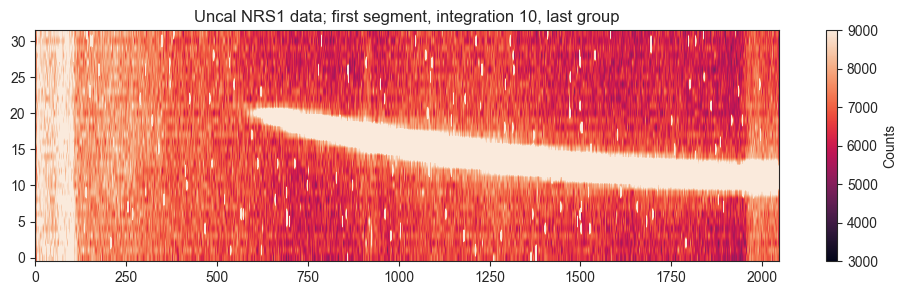

In [17]:
plt.figure(figsize=(12,3))

plt.title('Uncal NRS1 data; first segment, integration 10, last group')
im = plt.imshow(uncal_nrs1[0].data[10, -1, :, :], aspect = 'auto', origin = 'lower')
im.set_clim(3000,9000)

plt.colorbar(label = 'Counts')

What about the NRS2 data?

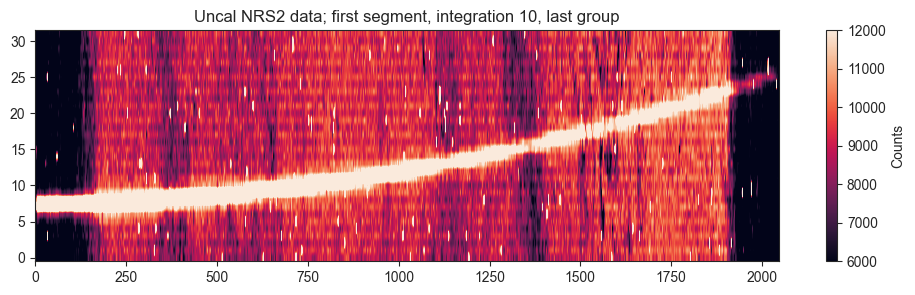

In [18]:
plt.figure(figsize=(12,3))

plt.title('Uncal NRS2 data; first segment, integration 10, last group')
im = plt.imshow(uncal_nrs2[0].data[10, -1, :, :], aspect = 'auto', origin = 'lower')
im.set_clim(6000,12000)

plt.colorbar(label = 'Counts')

The data looks great! The central, sword-like feature is the actual spectrum of WASP-39. NRS1 holds data from 3-4 microns, NRS2 from 4-5 microns. All the background structure one sees here, however, is mostly dominated by detector-level effects --- we deal with those in the next Section of this Notebook.

3.<font color='white'>-</font>A TSO tour through the `Detector1` stage <a class="anchor" id="setup"></a>
------------------

The `uncal` data products we loaded above contain a series of detector systematic effects that we need to remove before our data is ready for science. Now, we will move to calibrating those TSO `uncal` data products, which will take care of most of those effects. 

To perform this calibration, here we will follow most of the steps outlined in the `calwebb_detector1` or "Stage 1" processing described in the [JWST Calibration pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html) --- in particular, the one defined for "Near-IR" instruments, such as NIRSpec. This Stage 1 processing for Near-IR TSOs is defined by a series of steps, which in order are:

1. `group_scale` (not relevant for our datasets)
2. `dq_init`
3. `saturation`
4. `superbias`
5. `refpix`
6. `linearity`
7. `dark_current`
8. `jump`
9. `ramp_fitting`
10. `gain_scale` (not relevant for our datasets)

We will slightly modify and/or add some steps to suit our TSO needs below --- let's get started!

### 3.1<font color='white'>-</font>Checking data quality flags <a class="anchor" id="dqflags"></a>

An important component of any TSO analysis is to flag bad pixels, pixels identified as cosmic rays and/or identify saturated pixels. Bad pixels are, in fact, curated by the instrument teams in what we colloquially refer to as a "bad pixel mask" --- a mask one can "attach" to the data products with the JWST Calibration pipeline. This is exactly what the first step in the pipeline, the `dq_init` step, does. 

#### 3.1.1 Running & understanding the `dq_init` step

Let's run the `dq_init` step on the first segment of our data products for NRS1 and NRS2: 

In [19]:
# Let's run the DQ init step; first for the first segment of the NRS1 detector:
print('Running dq_init on NRS1:')
nrs1_seg1_dqinit = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs1[0])

# Now, same on the NRS2 detector:
print('Running dq_init on NRS2:')
nrs2_seg1_dqinit = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs2[0])

Running dq_init on NRS1:


2023-12-02 19:22:08,459 - CRDS - INFO -  Fetching  $HOME/crds_cache/mappings/jwst/jwst_nirspec_superbias_0064.rmap   30.2 K bytes  (1 / 8 files) (0 / 74.4 K bytes)
2023-12-02 19:22:09,275 - CRDS - INFO -  Fetching  $HOME/crds_cache/mappings/jwst/jwst_nirspec_mask_0034.rmap    2.4 K bytes  (2 / 8 files) (30.2 K / 74.4 K bytes)
2023-12-02 19:22:09,978 - CRDS - INFO -  Fetching  $HOME/crds_cache/mappings/jwst/jwst_nirspec_dark_0060.rmap   29.0 K bytes  (3 / 8 files) (32.6 K / 74.4 K bytes)
2023-12-02 19:22:10,753 - CRDS - INFO -  Fetching  $HOME/crds_cache/mappings/jwst/jwst_nirspec_0340.imap      5.2 K bytes  (4 / 8 files) (61.6 K / 74.4 K bytes)
2023-12-02 19:22:11,624 - CRDS - INFO -  Fetching  $HOME/crds_cache/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (5 / 8 files) (66.8 K / 74.4 K bytes)
2023-12-02 19:22:12,324 - CRDS - INFO -  Fetching  $HOME/crds_cache/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (6 / 8 files) (67.6 K / 74.4 K bytes)
2023-12-02

Running dq_init on NRS2:


2023-12-02 19:22:36,420 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2023-12-02 19:22:37,965 - stpipe.DQInitStep - INFO - Results used CRDS context: jwst_1152.pmap
2023-12-02 19:22:37,966 - stpipe.DQInitStep - INFO - Step DQInitStep done


All right, data-quality flags have been attached to our uncalibrated data products. To figure out why these are so useful, let's take a look at this bad pixel mask that was attached to our data products; in particular, let's peek at the one attached to the NRS1 detector products. This mask lives in the `pixeldq` attribute of our products (e.g., `nrs1_seg1_dqinit.pixeldq`). To familiarize ourselves with this, let's print the dimensions of this mask:

In [20]:
nrs1_seg1_dqinit.pixeldq.shape

(32, 2048)

As expected, it has the same size as our subarray data. [As per the documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=data%20quality%20flags#data-quality-flags), most data-quality (DQ) flags should be zero in the subarray; let's plot this array to see how many of them get away from this value and where:

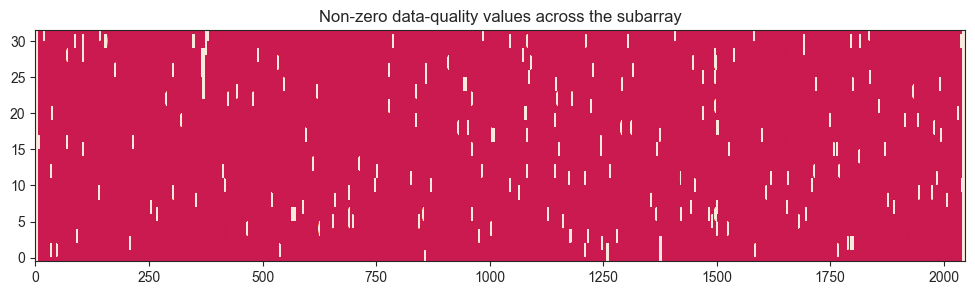

In [21]:
plt.figure(figsize=(12,3))

plt.title('Non-zero data-quality values across the subarray')
im = plt.imshow(nrs1_seg1_dqinit.pixeldq, aspect = 'auto', origin = 'lower')
im.set_clim(-0.5,0.5)

All right --- so there are "special" pixels all over the place! But, what are the `pixeldq` values telling us? Let's print the pixel in the very corner of the subarray:

In [22]:
nrs1_seg1_dqinit.pixeldq[0,0]

2147483648

[According to the documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=data%20quality%20flags#data-quality-flags), this pixel is a **reference pixel**. This makes sense: for NRS1 and NRS2 in this NIRSpec/G395H mode, the 4 pixel columns on the left-most end and the 4 pixel columns on the right-most end are indeed, reference pixels.

#### 3.1.2 Dynamically translating data-quality flags to human-readable form

Looking back and forth from the documentation page the data-quality flag values we read from our data-products is a very tedious task. In addition, as we will see below, a pixel can have eventually several flags (e.g., saturated, has a cosmic-ray, etc.) which will, in turn, change some of its data-quality flags to account for this. 

A handy function to convert those data-quality flag numbers to "human-readable" form is actually inside the `datamodels` class --- the `datamodels.dqflags`. This simply takes in a data-quality value, and spits out a `set` with strings defining what this is telling us given a so-called "mnemonic map" --- one which is actually already loaded in the `datamodels.dqflags.pixel` dictionary.

Let's try it out on the data-quality value we observed above:

In [23]:
datamodels.dqflags.dqflags_to_mnemonics(2147483648, mnemonic_map = datamodels.dqflags.pixel)

{'REFERENCE_PIXEL'}

Indeed, we get back what we knew --- that is a reference pixel! With this handy-dandy function, we can write a simple snippet to figure out the total tally of all bad pixels as follows:

In [24]:
# Create a dictionary that will save all types of bad pixels:
bad_pixels = {}

rows, columns = nrs1_seg1_dqinit.pixeldq.shape

# Iterate through every row and column:
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(nrs1_seg1_dqinit.pixeldq[row, column], 
                                                     mnemonic_map = datamodels.dqflags.pixel)

        # Iterate through the possible flags (it can be more than one!):
        for bp in bps:

            # If already in the bad_pixels dict, simply add 1 to the counter. If not, create and instantiate to one:
            if bp in bad_pixels.keys():

                bad_pixels[bp] += 1

            else:

                bad_pixels[bp] = 1

# Now print total tally:
total_pixels = rows * columns

print('From a total of ',total_pixels,' pixels, the "bad-pixel" tally is as follows:\n')
for bp in list( bad_pixels.keys() ):

    print('-> ',bad_pixels[bp], 
          'pixels marked as '+bp, 
          '({0:.2f}% of pixels)'.format(100*(bad_pixels[bp]/float(total_pixels))))

From a total of  65536  pixels, the "bad-pixel" tally is as follows:

->  256 pixels marked as REFERENCE_PIXEL (0.39% of pixels)
->  78 pixels marked as HOT (0.12% of pixels)
->  251 pixels marked as DO_NOT_USE (0.38% of pixels)
->  44 pixels marked as ADJ_OPEN (0.07% of pixels)
->  7 pixels marked as OPEN (0.01% of pixels)
->  112 pixels marked as DEAD (0.17% of pixels)
->  25 pixels marked as LOW_QE (0.04% of pixels)


Based on our discussion above, we can see some numbers above make sense. For instance, 256 `REFERENCE_PIXELS` make sense as there are a total of 8 columns (4 to the left, 4 to the right of the subarray) with reference pixels --- given the subarray height is 32 pixels, this gives a total of 256 reference pixels as expected.

Let's go ahead now and attach this bad pixel mask to all the segments of data, for both NRS1 and NRS2:

In [25]:
nsegments = 3
for i in range(nsegments):

    uncal_nrs1[i] = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs1[i])
    uncal_nrs2[i] = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs2[i])

2023-12-02 19:22:39,799 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-12-02 19:22:39,880 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 19:22:39,881 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-12-02 19:22:39,896 - stpipe.DQInitStep - INFO - Using MASK reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits
2023-12-02 19:22:43,358 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2023-12-02 19:22:45,327 - stpipe.DQInitStep - INFO - Results used CRDS context: jwst_1152.pmap
2023-12-02 19:22:45,328 - stpipe.DQInitStep - INFO - Step DQIn

<div class="alert alert-block alert-info"> <b>Note on saving data products with the JWST Calibration Pipeline</b>: Sometimes, one might find it useful to save data products after running each step into <code>.fits</code> files, so we can have "intermediate steps" stored in our system that we can check at a later time. This can be done when running any of the steps by adding the <code>save_results = True</code> flag to the step calls, e.g., <code>calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs1[i], save_results = True)</code>. An output directory can also be defined by using the <code>output_dir</code> parameter.

### 3.2<font color='white'>-</font>Identifying saturated pixels <a class="anchor" id="saturation"></a>


One very important detail in JWST data analysis involves checking which pixels are "saturated" or not. Saturation in the JWST context is an [instrument-by-instrument defined upper signal level](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-tso-saturation), typically defined as a limit above which detector effects not modeled by the pipeline might start to kick-in. As such, identifying which pixels are above this limit is important. In particular, the pipeline tends to omit those pixels from most analyses, as they might introduce unwanted systematic effects.

#### 3.2.1 Running and understanding the `saturation` step

Through the analysis of calibration datasets, the JWST instrument teams have defined signal values for each pixel above which they are considered as "saturated". This identification is done through the `saturation` step --- the next step of the JWST pipeline for Detector 1. Let's run it for the very first segment of data for NRS1:

In [26]:
# Run saturation step:
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs1[0])

2023-12-02 19:23:52,146 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-12-02 19:23:52,228 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 19:23:52,229 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}
2023-12-02 19:23:52,244 - stpipe.SaturationStep - INFO - Using SATURATION reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits
2023-12-02 19:24:05,916 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2023-12-02 19:24:19,850 - stpipe.SaturationStep - INFO - Detected 789 saturated pi

The saturation step works by primarily comparing the observed count values with the saturation signal-levels defined for each pixel in a reference file. As can be seen above, that reference file is indicated by the line `stpipe.SaturationStep - INFO - Using SATURATION reference file [yourfile]`. In the case of our run at the time of writing, this was the `jwst_nirspec_saturation_0028.fits` file --- but this might change as new analyses are made and the reference files get updated. 

In addition, at the time of writing, the `saturation` step in the JWST Calibration pipeline [by default flags not only pixels that exceed the signal limit defined by the instrument teams but also all `n_pix_grow_sat` pixels around it](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/jwst-operations-pipeline-build-information/jwst-operations-pipeline-build-8-0-release-notes#JWSTOperationsPipelineBuild8.0ReleaseNotes-charge_spilling); which at the time of writing is set to a default of `1`. That means that if a given pixel exceeds the signal limit, all 8 pixels around it will be marked as saturated as well. This is done because it has been observed that "charge spilling" can be an issue --- i.e., charge going from one pixel to another. While such migration of charge happens at a wide range of count levels, this is particularly dramatic when a pixel saturates --- reason by which this is set in the pipeline.

We can check which pixels are saturated in a similar way as to how we checked the data-quality flags in [Section 3.1](#dqflags). The only difference with that analysis is that saturated pixels are integration and group-dependant, i.e., a property of a given pixel _in a given integration and group_. In other words, a pixel that is saturated in one integration and group might have "recovered" by the next integration and group.

To figure out the data-quality for all integrations and all groups we look at the `groupdq` attribute of our data products instead of the `pixeldq` which we used above. To familiarize ourselves with this, let's print the dimensions of this array first:

In [27]:
saturation_results.groupdq.shape

(155, 70, 32, 2048)

As expected, it has dimensions `(integrations, groups, row pixels, column pixels)`, just like the `data` array. The flags in the `groupdq` array follow the same structure as [all the data-quality flags described in the documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=data%20quality%20flags#data-quality-flags). 

#### 3.2.2 Exploring saturated pixels via the `groupdq` array

To illustrate how to use the `groupdq`, let's pick the last group of integration 10 again and see if any pixels seem to be saturated --- we also count all of the saturated pixels:

In [28]:
# Iterate through every row and column of integration number 10, last group:
integration, group = 10, -1
nsaturated = 0
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(saturation_results.groupdq[integration, group, row, column], 
                                                      mnemonic_map = datamodels.dqflags.pixel)
        
        # Check if pixel is saturated; if it is...
        if 'SATURATED' in bps:

            # ...print which pixel it is, and...
            print('Pixel ({0:},{1:}) is saturated in integration 10, last group'.format(row, column))

            # ...count it:
            nsaturated += 1

print('\nA total of {0:} out of {1:} pixels ({2:.2f}%) are saturated'.format(nsaturated, 
                                                                             rows*columns, 
                                                                             100 * nsaturated / float(rows * columns)
                                                                            )
     )

Pixel (2,99) is saturated in integration 10, last group
Pixel (2,100) is saturated in integration 10, last group
Pixel (2,101) is saturated in integration 10, last group
Pixel (3,99) is saturated in integration 10, last group
Pixel (3,100) is saturated in integration 10, last group
Pixel (3,101) is saturated in integration 10, last group
Pixel (4,99) is saturated in integration 10, last group
Pixel (4,100) is saturated in integration 10, last group
Pixel (4,101) is saturated in integration 10, last group
Pixel (4,844) is saturated in integration 10, last group
Pixel (4,845) is saturated in integration 10, last group
Pixel (4,846) is saturated in integration 10, last group
Pixel (5,844) is saturated in integration 10, last group
Pixel (5,845) is saturated in integration 10, last group
Pixel (5,846) is saturated in integration 10, last group
Pixel (6,844) is saturated in integration 10, last group
Pixel (6,845) is saturated in integration 10, last group
Pixel (6,846) is saturated in inte

As can be seen, not many pixels are saturated on a given group. Let's see how the up-the-ramp samples look like for one of those pixels --- let's say, pixel `(3, 100)`. Let's show in the same plot the group data-quality flags at each group:

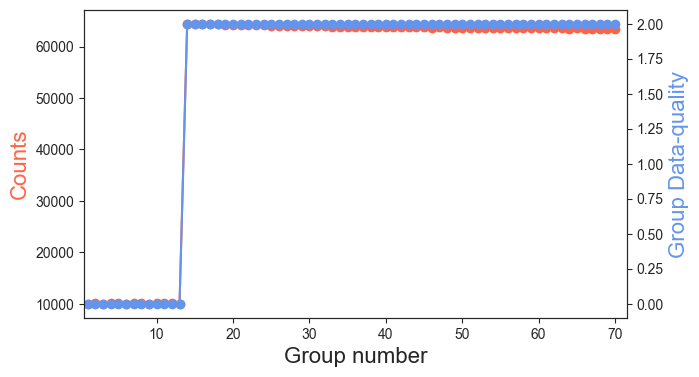

In [29]:
pixel_row, pixel_column = 3, 100

plt.figure(figsize=(7,4))

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.data[integration, :, pixel_row, pixel_column], 
         'o-', color = 'tomato')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16, color = 'tomato')

plt.twinx()

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.groupdq[integration, :, pixel_row, pixel_column], 
         'o-', color = 'cornflowerblue')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.ylabel('Group Data-quality', fontsize = 16, color = 'cornflowerblue')

plt.show()

Very interesting plot! Note that all groups appear to be saturated after group ~13. Likely a cosmic-ray hit happened at this group which left the pixel at a very high count number from group 14 up to the end of the ramp.

#### 3.2.3 Setting custom saturation limits with the `saturation` reference file

TSOs often obtain data from bright stars that might quickly (i.e., first few groups) give rise to saturated pixels. As described in some early JWST results (see, e.g., [Rustamkulov et al., 2023](https://www.nature.com/articles/s41586-022-05677-y)), in some cases one might even want to be a bit more aggressive on the level of saturation allowed in a given dataset in order to improve on the reliability of the results. As such, understanding how to modify the level of saturation allowed in a given dataset might turn out to be an important skill on real TSO data analysis. 

The key file that sets the limits used to call a pixel "saturated"  is the reference file of the `saturation` step. 

As discussed above, this can be seen directly on the outputs of the `saturation` step while its running, but it's also saved in our data products:

In [30]:
saturation_results.meta.ref_file.saturation.name

'crds://jwst_nirspec_saturation_0028.fits'

We can actually load this reference file using the `SaturationModel` as follows:

In [31]:
# Base directory where reference files are stored (this was defined in the Setup section above):
base_ref_files = '$HOME/crds_cache/references/jwst/nirspec/'

# Read it in:
saturation_ref_file = datamodels.SaturationModel(base_ref_files+saturation_results.meta.ref_file.saturation.name[7:])

More often than not, however, the saturation reference file might not match exactly the dimensions of our subarray. This is because the reference file might be padded to match several other subarrays, and thus we have to figure out how to "cut" it to match our data. This is, in fact, our case:

In [32]:
saturation_ref_file.data.shape

(260, 2048)

Luckily, the JWST calibration pipeline has a handy function to transform the dimensions between instruments --- this is the `jwst.lib.reffile_utils.get_subarray_model` function, which recieves an input data model (e.g., the one from our data) along with the reference file, and spits out the same reference file model but with the right dimensions. Let's use it:

In [33]:
tailored_saturation_ref_file = jwst.lib.reffile_utils.get_subarray_model(saturation_results, saturation_ref_file)

Indeed, now our "tailored" reference file matches our science data dimensions:

In [34]:
tailored_saturation_ref_file.data.shape

(32, 2048)

Let's see how the saturation map looks like for our subarray:

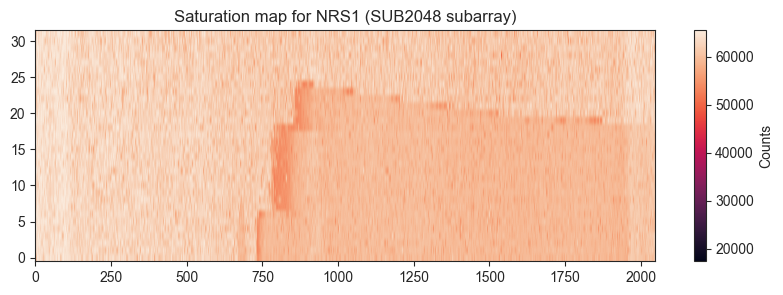

In [35]:
plt.figure(figsize=(10,3))

plt.title('Saturation map for NRS1 (SUB2048 subarray)')
im = plt.imshow(tailored_saturation_ref_file.data, aspect = 'auto', origin = 'lower', interpolation = None)

plt.colorbar(label = 'Counts')

plt.show()

There's clearly some structure, albeit is not exactly clear what values different pixels take. To visualize this, let's print the saturation limit for pixel `(3,100)`, the one we explored above:

In [36]:
tailored_saturation_ref_file.data[pixel_row, pixel_column]

61564.0

If the counts surpass this limit, the pixel will be considered saturated. To see if this was the case, let's repeat the plot above marking this signal limit:

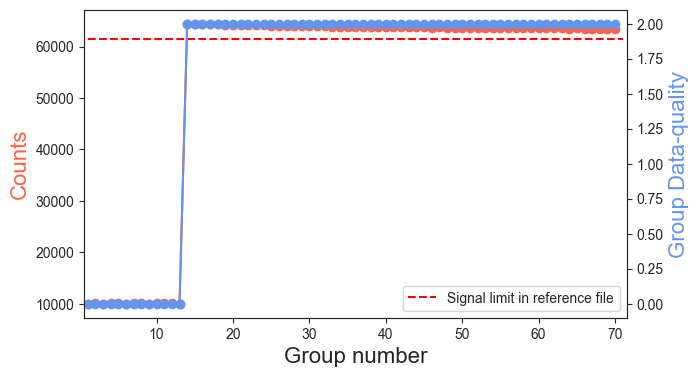

In [37]:
pixel_row, pixel_column = 3, 100

plt.figure(figsize=(7,4))

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.data[integration, :, pixel_row, pixel_column], 
         'o-', color = 'tomato')

plt.plot([1, saturation_results.data.shape[1]+1], 
         [tailored_saturation_ref_file.data[pixel_row, pixel_column], 
          tailored_saturation_ref_file.data[pixel_row, pixel_column]],
         'r--', 
         label = 'Signal limit in reference file'
        )

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16, color = 'tomato')
plt.legend()

plt.twinx()

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.groupdq[integration, :, pixel_row, pixel_column], 
         'o-', color = 'cornflowerblue')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.ylabel('Group Data-quality', fontsize = 16, color = 'cornflowerblue')

plt.show()

Indeed, this is the case! Note that, as described above, by default for NIRSpec not only this pixel gets marked as saturated, but all pixels around it. To see this, note for instance the same plot as above but for pixel (2,99):

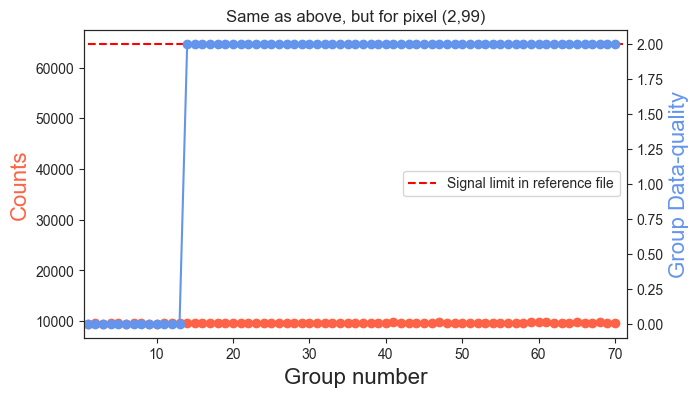

In [38]:
pixel_row, pixel_column = 2, 99

plt.figure(figsize=(7,4))

plt.title('Same as above, but for pixel (2,99)')
plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.data[integration, :, pixel_row, pixel_column], 
         'o-', color = 'tomato')

plt.plot([1, saturation_results.data.shape[1]+1], 
         [tailored_saturation_ref_file.data[pixel_row, pixel_column], 
          tailored_saturation_ref_file.data[pixel_row, pixel_column]],
         'r--', 
         label = 'Signal limit in reference file'
        )

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16, color = 'tomato')
plt.legend()

plt.twinx()

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.groupdq[integration, :, pixel_row, pixel_column], 
         'o-', color = 'cornflowerblue')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.ylabel('Group Data-quality', fontsize = 16, color = 'cornflowerblue')

plt.show()

Note how the signal level has not gone above the limit in the reference file, but it is marked as saturated because pixel (3,100) is. Again, this is to account for possible charge spilling to the pixel.

Now, what if we wanted to mark as saturated all pixels, say, larger than 50\% these saturation values? Well, we can directly modify the reference file and repeat the calculation pointing at it:

In [39]:
saturation_ref_file.data = saturation_ref_file.data * 0.5

To incorporate this new reference file, we simply use the `override_saturation` flag, passing this new `SaturationModel` along: 

In [40]:
# Run saturation step:
saturation_results2 = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs1[0], 
                                                                            override_saturation = saturation_ref_file)

2023-12-02 19:24:22,108 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-12-02 19:24:22,192 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 19:24:22,193 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}
2023-12-02 19:24:22,200 - stpipe.SaturationStep - INFO - Using SATURATION reference file <SaturationModel(260, 2048) from jwst_nirspec_saturation_0028.fits>
2023-12-02 19:24:24,680 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2023-12-02 19:24:38,144 - stpipe.SaturationStep - INFO - Detected 7772 saturated pixels
2

Let's see how many pixels are now counted as saturated:

In [41]:
# Iterate through every row and column of integration number 10, last group:
integration, group = 10, -1
nsaturated = 0
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(saturation_results2.groupdq[integration, group, row, column], 
                                                      mnemonic_map = datamodels.dqflags.pixel)
        
        # Check if pixel is saturated; if it is...
        if 'SATURATED' in bps:

            # ...print which pixel it is, and...
            print('Pixel ({0:},{1:}) is saturated in integration 10, last group'.format(row, column))

            # ...count it:
            nsaturated += 1

print('\nA total of {0:} out of {1:} pixels ({2:.2f}%) are saturated'.format(nsaturated, 
                                                                             rows*columns, 
                                                                             100 * nsaturated / float(rows * columns)
                                                                            )
     )

Pixel (0,34) is saturated in integration 10, last group
Pixel (0,35) is saturated in integration 10, last group
Pixel (0,36) is saturated in integration 10, last group
Pixel (0,1362) is saturated in integration 10, last group
Pixel (0,1363) is saturated in integration 10, last group
Pixel (0,1364) is saturated in integration 10, last group
Pixel (1,34) is saturated in integration 10, last group
Pixel (1,35) is saturated in integration 10, last group
Pixel (1,36) is saturated in integration 10, last group
Pixel (1,1362) is saturated in integration 10, last group
Pixel (1,1363) is saturated in integration 10, last group
Pixel (1,1364) is saturated in integration 10, last group
Pixel (2,34) is saturated in integration 10, last group
Pixel (2,35) is saturated in integration 10, last group
Pixel (2,36) is saturated in integration 10, last group
Pixel (2,91) is saturated in integration 10, last group
Pixel (2,92) is saturated in integration 10, last group
Pixel (2,93) is saturated in integra

As expected, a much bigger portion! About 5\% of the pixels in the subarray are now masked (against 0.04\% from before) as saturated thanks to our higher threshold for flagging.

<div class="alert alert-block alert-info"> <b>Note on manually setting the saturation limit</b>: Setting the saturation limit manually should be done with care, and we recommend trying different saturation levels to check whether TSO science is impacted by this choice. In particular, we suggest to <i>never</i> set limits that are above the thresholds defined by the instrument teams, as these are typically set to levels above which the non-linearity correction (see below) is not expected to work.</div>

Before moving to the next step, let's run the saturation step on both NRS1 and NRS2:

In [42]:
nsegments = 3
for i in range(nsegments):

    uncal_nrs1[i] = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs1[i])
    uncal_nrs2[i] = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs2[i])

2023-12-02 19:24:39,894 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-12-02 19:24:39,958 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 19:24:39,959 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}
2023-12-02 19:24:39,973 - stpipe.SaturationStep - INFO - Using SATURATION reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits
2023-12-02 19:24:41,690 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2023-12-02 19:24:55,184 - stpipe.SaturationStep - INFO - Detected 789 saturated pi

### 3.3<font color='white'>-</font>Removing detector-level effects: the `superbias` and `refpix` steps <a class="anchor" id="refpix"></a>

So far, we have focused on flagging pixels for various effects (e.g., bad pixels, saturation) but we haven't worked directly with the actual counts on our data. In this Section, we deal with various (non-astrophysical) detector-level effects present in our data through two steps in the JWST Calibration pipeline: the `superbias` and the `refpix` steps. 

#### 3.3.1 Removing the pedestal from the detector: the `superbias` step

All detectors have mostly stable, factory-defined pedestal levels, which can be closely monitored with the right calibration exposures. Indeed, instrument teams closely monitor and refine this via what is called the "super" bias --- the spatial shape of this pedestal. The JWST Calibration pipeline substracts this pedestal from data via the `superbias` step.

Applying this correction to the data is very simple to do; let's apply it once again to the first segment of data for the NRS1 detector, so we can check how our data changes after applying the step:

In [43]:
superbias_results = calwebb_detector1.superbias_step.SuperBiasStep.call(uncal_nrs1[0])

2023-12-02 19:27:02,837 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2023-12-02 19:27:02,914 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 19:27:02,914 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-12-02 19:27:02,930 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits
2023-12-02 19:27:08,902 - stpipe.SuperBiasStep - INFO - Results used CRDS context: jwst_1152.pmap
2023-12-02 19:27:08,903 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep done


Once again, we can see that there is a particular reference file being used to remove the pedestal, `jwst_nirspec_superbias_0427.fits`, which can be explored in a similar way as how we explored the reference file for the `saturation` step above. Let's see how our data changed after applying this pedestal removal --- let's again take the last group of integration 10 as an example:

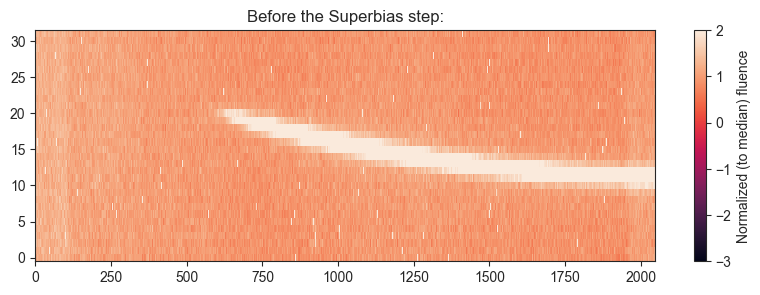

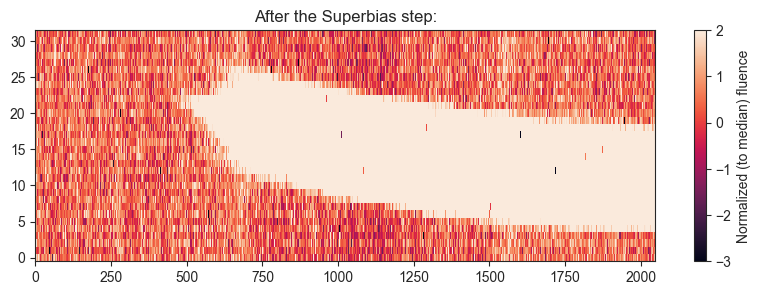

In [44]:
# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(uncal_nrs1[0].data[10,-1,:,:] / np.nanmedian(uncal_nrs1[0].data[10,-1,:,:]), \
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-3,2)
plt.title('Before the Superbias step:')

plt.colorbar(label = 'Normalized (to median) fluence')

# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(superbias_results.data[10,-1,:,:] / np.nanmedian(superbias_results.data[10,-1,:,:]), \
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-3,2)
plt.title('After the Superbias step:')
plt.colorbar(label = 'Normalized (to median) fluence')

plt.show()

Wow! That's a huge change. Overall, this looks much better. Let's plot the profiles of pixel column index 1500 to have a closer look:

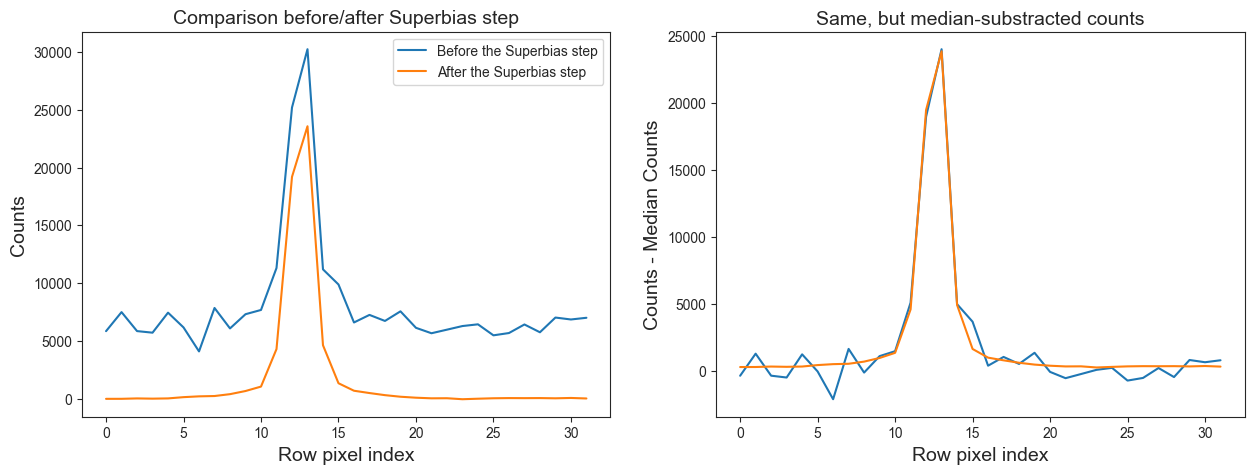

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(uncal_nrs1[0].data[10,-1,:,1500], label = 'Before the Superbias step')
ax[0].plot(superbias_results.data[10,-1,:,1500], label = 'After the Superbias step')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Comparison before/after Superbias step', fontsize = 14)
ax[0].legend()

ax[1].set_title('Same, but median-substracted counts', fontsize = 14)
ax[1].plot(uncal_nrs1[0].data[10,-1,:,1500] - np.nanmedian(uncal_nrs1[0].data[0,-1,:,1500]))
ax[1].plot(superbias_results.data[10,-1,:,1500] - np.nanmedian(superbias_results.data[0,-1,:,1500]))
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts - Median Counts', fontsize = 14)

plt.show()

As can be seen, a ton of structure has been removed. Also, all the pixels seem to be at the same background level. This is a good sign that the Superbias correction has worked, in principle, correctly. 

However, if we take a more detailed look at background pixels, we can note an interesting pattern. Let's plot a similar cut to the one above, but for column 250 --- which is far away from any illuminted pixels in the detector. Let's also plot the last superbias-corrected group and the second-to-last superbias-corrected group:

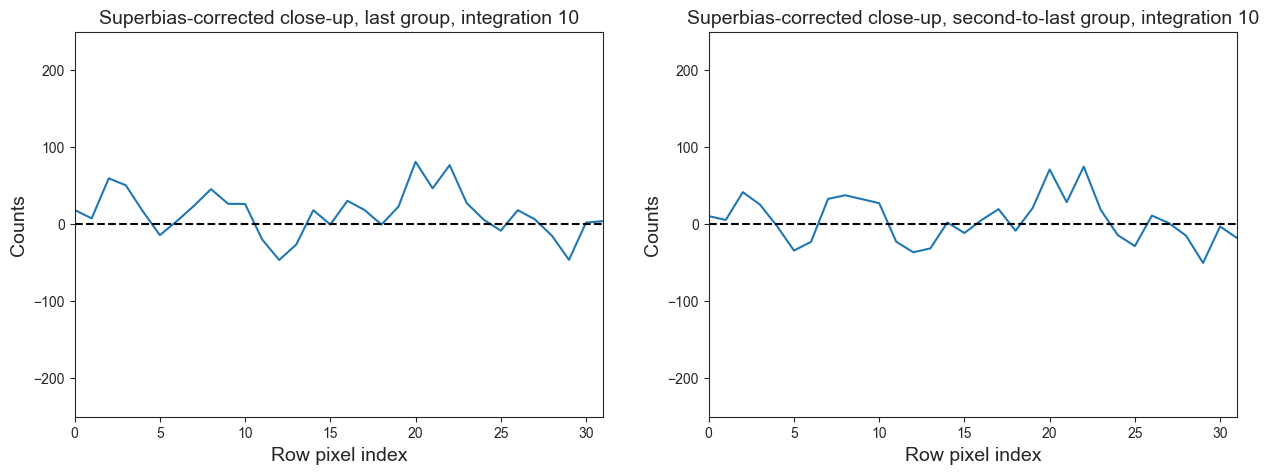

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(superbias_results.data[10,-1,:,250])
ax[0].plot([0, 32], [0, 0], 'k--')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Superbias-corrected close-up, last group, integration 10', fontsize = 14)
ax[0].set_ylim(-250,250)
ax[0].set_xlim(0,31)

ax[1].set_title('Superbias-corrected close-up, second-to-last group, integration 10', fontsize = 14)
ax[1].plot(superbias_results.data[10,-2,:,250])
ax[1].plot([0, 32], [0, 0], 'k--')
ax[1].set_ylim(-250,250)
ax[1].set_xlim(0,31)
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts', fontsize = 14)

plt.show()

Note how the pedestal correction the `superbias` step has, first of all, **not** brought the background down to **exactly** zero. The answer to this behavior is that there are other, group-dependant detector effects that need to be removed. These are the ones the so-called "reference pixels" in the detector aim at correcting for, which is done in the JWST Calibration pipeline via the `refpix` step --- the step we cover next in this Notebook.

#### 3.3.2 Removing group-dependant detector effects: the `refpix` step

All the JWST detectors contain reference pixels, typically located in some (or all) of the edges of the detectors. These pixels are ones for which their "sensitivity to light" has been deactivated, and are thus useful for tracking detector-level effects happening at the time of our observations. While all detectors have those, **not all detector subarrays** contain reference pixels. Some, like in our case, contain reference pixels only in certain portions of the subarray.

Let's visualize where those reference pixels are in our subarray by using the `pixeldq` flags:

In [47]:
# Create an array that will save locations of reference pixels:
reference_pixels = np.zeros([rows, columns])

# Iterate through every row and column:
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(superbias_results.pixeldq[row, column], 
                                                      mnemonic_map = datamodels.dqflags.pixel)

        if 'REFERENCE_PIXEL' in bps:

            reference_pixels[row, column] = 1

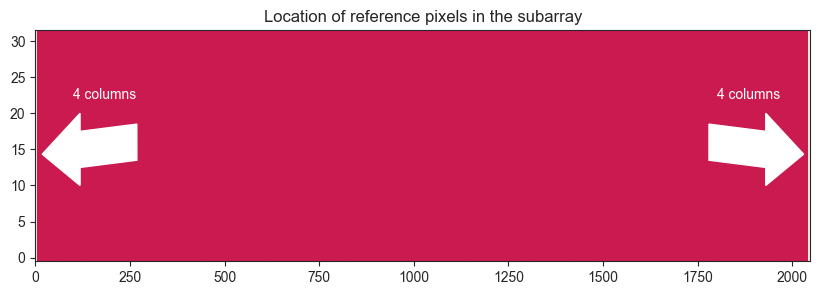

In [48]:
plt.figure(figsize=(10,3))

plt.title('Location of reference pixels in the subarray')
im = plt.imshow(reference_pixels, aspect = 'auto', origin = 'lower')

# Arrows to indicate edges:
plt.text(1800, 22, '4 columns', color = 'white')
plt.arrow(1780, 16, 150, -1, width = 5, head_width = 10, head_length = 100, color = 'white')

plt.text(100, 22, '4 columns', color = 'white')
plt.arrow(268, 16, -150, -1, width = 5, head_width = 10, head_length = 100, color = 'white')

im.set_clim(-0.5,0.5)

plt.show()

Note the white edges to the left and the right of the plot above (indicated by arrows)? That's the location of the reference pixels for our subarray. In other words, our subarray has reference pixels to the left and right-most sides, but not on the top or bottom part.

This is important to note because when one inspects NIRSpec/G395H data, there are clearly row-by-row effects and column-by-column effects. **The most important row-by-row effect is the so-called "odd/even" effect**, whose symptom is that of alternating flux "jumps" that is seen in all odd columns at one level, and at even columns at another level. To illustrate this, let's plot all the odd and even rows in our subarray for integration 10, last group:

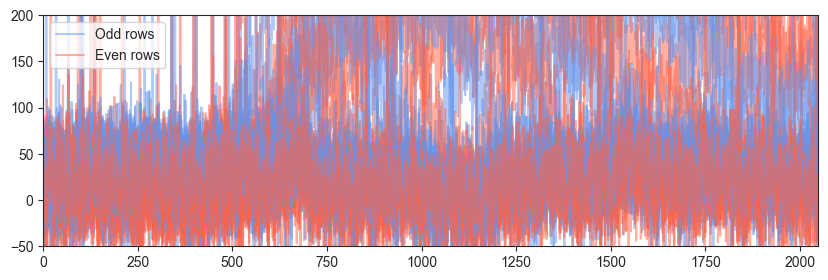

In [49]:
plt.figure(figsize=(10,3))

for i in range(32):

    if i < 2:

        if i % 2:

            name = 'Even rows'

        else:

            name = 'Odd rows'

    else:

        name = None

    if i % 2:

        plt.plot(superbias_results.data[10, -1, i, :], color = 'tomato', alpha = 0.5, label = name)

    else:

        plt.plot(superbias_results.data[10, -1, i, :], color = 'cornflowerblue', alpha = 0.5, label = name)

plt.legend()
plt.xlim(0, 2048)
plt.ylim(-50,200)

plt.show()

Note how the red and blue curves are all offset from one another due to this "odd/even" effect. On the other hand, **the most important "column-by-column" detector effect is 1/f noise**. A symptom of this effect is an apparent vertical "banding" on the detector, which will become very apparent once we apply the reference pixel correction. **There's a third important detector effect which offsets all pixels up and down throughout the detector on a group-level basis**. As can be seen, the row-by-row and this third, all-pixel offset should be corrected by the reference pixels at the edge of our subarray --- but the 1/f, column-by-column effect should remain.

Let's apply the `refpix` step to check how our data looks like after it:

In [50]:
refpix_results = calwebb_detector1.refpix_step.RefPixStep.call(superbias_results)

2023-12-02 19:27:11,559 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2023-12-02 19:27:11,680 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 19:27:11,681 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True, 'ovr_corr_mitigation_ftr': 3.0}
2023-12-02 19:27:15,459 - stpipe.RefPixStep - INFO - NIR subarray data
2023-12-02 19:27:15,468 - stpipe.RefPixStep - INFO - Single readout amplifier used
2023-12-02 19:27:15,468 - stpipe.RefPixStep - INFO - The following parameter is valid for this

Let's plot once again the figures above. First, a vertical cut of the profile at pixel column index 250:

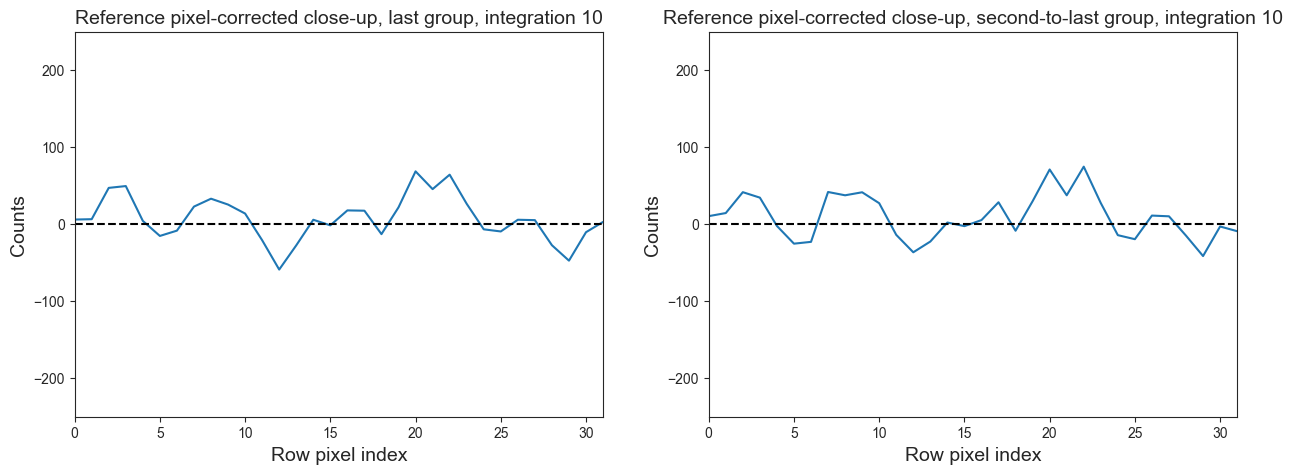

In [51]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(refpix_results.data[10,-1,:,250])
ax[0].plot([0, 32], [0, 0], 'k--')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Reference pixel-corrected close-up, last group, integration 10', fontsize = 14)
ax[0].set_ylim(-250,250)
ax[0].set_xlim(0,31)

ax[1].set_title('Reference pixel-corrected close-up, second-to-last group, integration 10', fontsize = 14)
ax[1].plot(refpix_results.data[10,-2,:,250])
ax[1].plot([0, 32], [0, 0], 'k--')
ax[1].set_ylim(-250,250)
ax[1].set_xlim(0,31)
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts', fontsize = 14)

plt.show()

Nice, now flux is down to the zero-level. What about the odd-even effect?

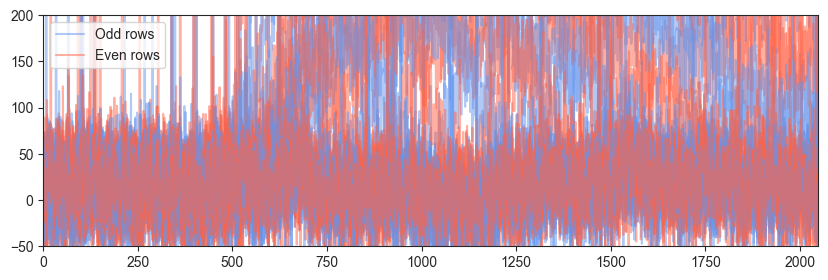

In [52]:
plt.figure(figsize=(10,3))

for i in range(32):

    if i < 2:

        if i % 2:

            name = 'Even rows'

        else:

            name = 'Odd rows'

    else:

        name = None

    if i % 2:

        plt.plot(refpix_results.data[10, -1, i, :], color = 'tomato', alpha = 0.5, label = name)

    else:

        plt.plot(refpix_results.data[10, -1, i, :], color = 'cornflowerblue', alpha = 0.5, label = name)

plt.legend()
plt.xlim(0, 2048)
plt.ylim(-50,200)

plt.show()

Gone, too!

Let's plot the 2D frame of this integration to see how the data looks like:

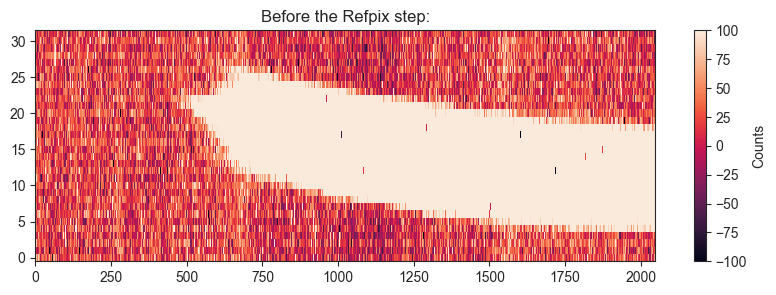

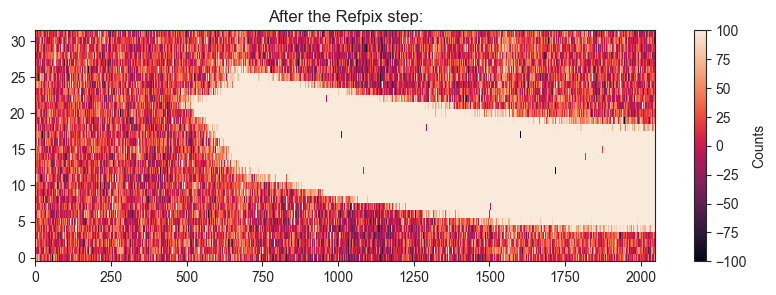

In [53]:
# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(superbias_results.data[10,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.title('Before the Refpix step:')

plt.colorbar(label = 'Counts')

# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(refpix_results.data[10,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.title('After the Refpix step:')
plt.colorbar(label = 'Counts')

plt.show()

Wow! That looks much better. Note how most of the horizontal structure has been removed.

It is interesting to note that the "banding" on the columns, as discussed above, has not dissapeared. This is more evident when plotting a series of groups from different integrations; let's plots the groups from integrations 10, 11 and 12:

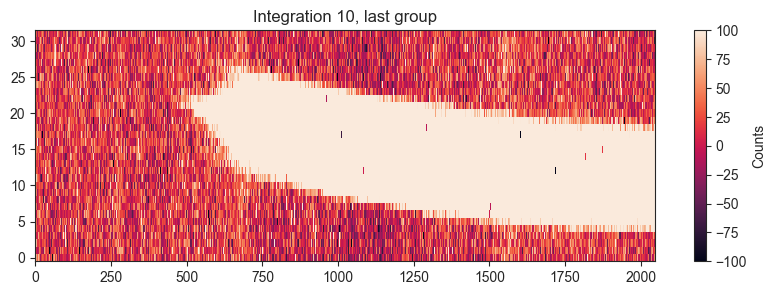

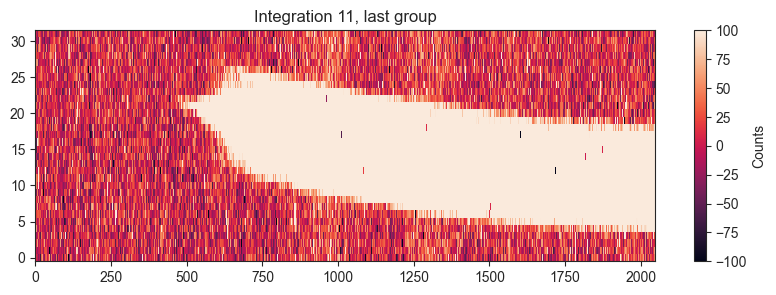

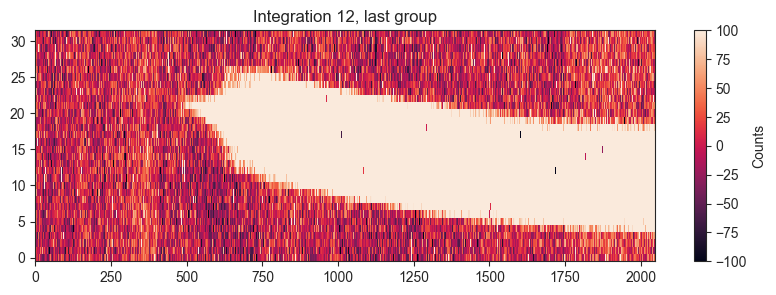

In [54]:
# Integration 10, last group
plt.figure(figsize=(10,3))
plt.title('Integration 10, last group')
im = plt.imshow(refpix_results.data[10,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.colorbar(label = 'Counts')

# Integration 10, last group
plt.figure(figsize=(10,3))
plt.title('Integration 11, last group')
im = plt.imshow(refpix_results.data[11,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.colorbar(label = 'Counts')

# Integration 12, last group
plt.figure(figsize=(10,3))
plt.title('Integration 12, last group')
im = plt.imshow(refpix_results.data[12,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.colorbar(label = 'Counts')

plt.show()

This is, once again, expected as there are no reference pixels in the columns. We will explore how to correct this after going with the `linearity` correction/step, which we discuss next. Before moving on, we apply the superbias and reference pixel step to both detectors, all segments:

In [55]:
nsegments = 3
for i in range(nsegments):

    # Apply superbias and refpix to NRS1:
    uncal_nrs1[i] = calwebb_detector1.superbias_step.SuperBiasStep.call(uncal_nrs1[i])
    uncal_nrs1[i] = calwebb_detector1.refpix_step.RefPixStep.call(uncal_nrs1[i])
    
    # Apply superbias and refpix to NRS2:
    uncal_nrs2[i] = calwebb_detector1.superbias_step.SuperBiasStep.call(uncal_nrs2[i])
    uncal_nrs2[i] = calwebb_detector1.refpix_step.RefPixStep.call(uncal_nrs2[i])

2023-12-02 19:28:05,898 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2023-12-02 19:28:06,062 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 19:28:06,063 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-12-02 19:28:06,078 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits
2023-12-02 19:28:11,117 - stpipe.SuperBiasStep - INFO - Results used CRDS context: jwst_1152.pmap
2023-12-02 19:28:11,119 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep done
2023-12-02 19:28:11,205 - stpipe.RefPixStep - IN

### 3.4<font color='white'>-</font>Linearity corrections <a class="anchor" id="linearity"></a>

As a pixel accumulates charge, it becomes less and less efficient at generating charge-carriers and/or holding that charge in place. A consequence of this is that the raw -uncalibrated- up-the-ramp samples in JWST detectors are non-linear, with the pixels at lower fluences being almost linear and pixels near the saturation ranges deviating significantly from this behavior. This is the behavior that the `linearity` step in the JWST Calibration pipeline aims to fix.

#### 3.4.1 Visualizing and correcting for non-linearity with the `linearity` step

To visualize the non-linearity of the up-the-ramp samples, let's take a look at the samples of one of the brightest pixels in our subarray, pixel `(12, 2000)` --- say for integration number 10. Let's plot on top a line fitted to the first 10 pixels, which should be the most "linear" of all pixels:

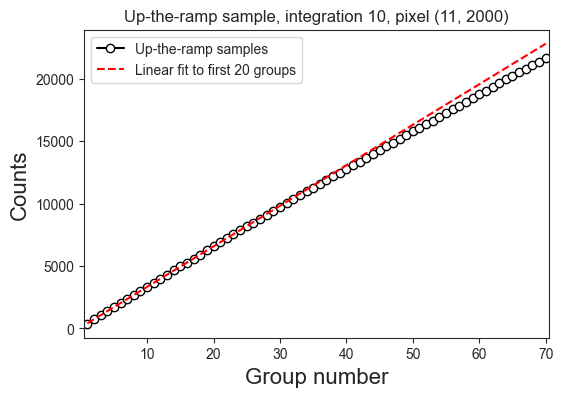

In [56]:
ngroups = uncal_nrs1[0].data.shape[1]
group = np.arange(ngroups) + 1

first_groups = 20

coeff = np.polyfit(group[:first_groups],  uncal_nrs1[0].data[10, :first_groups, 11, 2000], 1)

plt.figure(figsize=(6,4))

plt.title('Up-the-ramp sample, integration 10, pixel (11, 2000)')

plt.plot( group, uncal_nrs1[0].data[10, :, 11, 2000], 'o-', color = 'black', mfc = 'white', label = 'Up-the-ramp samples')
plt.plot( group, np.polyval(coeff, group), 'r--', label = 'Linear fit to first '+str(first_groups)+' groups')

plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.legend()
plt.xlim(0.5, 70.5)

plt.show()

Ah --- the ramp is _clearly_ non-linear! Let's apply the `linearity` step to the very first segment of NRS1 to see how well this gets corrected:

In [57]:
# Run linearity step:
linearity_results = calwebb_detector1.linearity_step.LinearityStep.call(uncal_nrs1[0])

2023-12-02 20:16:16,893 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-12-02 20:16:16,958 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 20:16:16,959 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-12-02 20:16:16,974 - stpipe.LinearityStep - INFO - Using Linearity reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits
2023-12-02 20:16:17,004 - stpipe.LinearityStep - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored
2023-12-02 20:23:18,923 - stpipe.LinearityStep - INFO - Results used CRDS conte

Let's try the same plot as above, but with the linearity-corrected data:

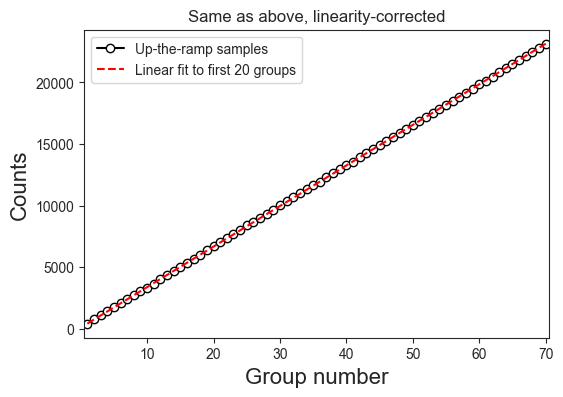

In [58]:
ngroups = uncal_nrs1[0].data.shape[1]
group = np.arange(ngroups) + 1

first_groups = 20

coeff = np.polyfit(group[:first_groups],  linearity_results.data[10, :first_groups, 11, 2000], 1)

plt.figure(figsize=(6,4))

plt.title('Same as above, linearity-corrected')

plt.plot( group, linearity_results.data[10, :, 11, 2000], 'o-', color = 'black', mfc = 'white', label = 'Up-the-ramp samples')
plt.plot( group, np.polyval(coeff, group), 'r--', label = 'Linear fit to first '+str(first_groups)+' groups')

plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.legend()
plt.xlim(0.5, 70.5)

plt.show()

Ah, much better! 

#### 3.4.2 Testing the accuracy of the `linearity` step

It is important to realize that the linearity corrections that the JWST Calibration pipeline applies through the `linearity` step are _not_ perfect. While this is difficult to see with a single integration, this can be studied with multiple integrations --- which helps us beat the noise embedded on single up-the-ramp samples. 

One trick to glance at how the linearity of the up-the-ramp samples evolves as one goes up-the-ramp is to note that if the detector is linear, it doesn't matter at which up-the-ramp sample one looks at, the **fluence level should change from group-to-group at _the same rate_ on average**. So one can quickly investigate if linearity is an issue (and if the pipeline is correctly correcting for it) by:

1. Taking the difference in fluence between two subsequent groups (say, the last two).
2. Taking the difference in fluence between two _other_ subsequent groups (say, the first two).
3. Take the ratio between those differences.

If the detector is linear, then all the pixels should fall around a ratio of 1. Do they? Let's try this experiment out. Let's first take the difference of the last two and first two groups for all the pixels of all the integrations of the **uncorrected** data --- then take the ratio of those. As we saw above, this should scream "non-linearity" all over!

In [59]:
last_pair = uncal_nrs1[0].data[:, -1, :, :] - uncal_nrs1[0].data[:, -2, :, :]
first_pair = uncal_nrs1[0].data[:, 1, :, :] - uncal_nrs1[0].data[:, 0, :, :]

In [60]:
ratio = last_pair / first_pair

2023-12-02 20:23:19,033 - stpipe - WARNING - /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T/ipykernel_86303/940140270.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = last_pair / first_pair



Let's now flatten those arrays and plot them as a function of total fluence at the very last group. If linearity weren't an issue, all of these should line around 1:

In [61]:
flattened_ratio = ratio.flatten()
flattened_fluences = uncal_nrs1[0].data[:, -1, :, :].flatten()

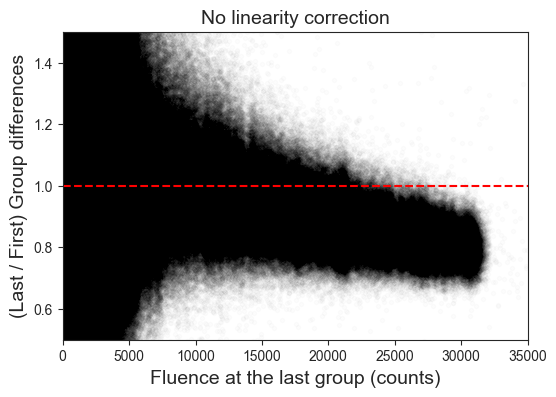

In [62]:
plt.figure(figsize = (6,4))
plt.plot(flattened_fluences, flattened_ratio, '.', alpha = 0.01, color = 'black')
plt.plot([0,35000], [1., 1.], 'r--')
plt.ylim(0.5,1.5)
plt.xlim(0,35000)
plt.xlabel('Fluence at the last group (counts)', fontsize = 14)
plt.ylabel('(Last / First) Group differences', fontsize = 14)
plt.title('No linearity correction', fontsize = 14)

plt.show()

Indeed, the data does _not_ line up around 1. So linearity _is_ an issue (as we already observed in the up-the ramp samples before)!

All right, let's try the same experiment but now on the linearity-corrected data:

In [63]:
corrected_last_pair = linearity_results.data[:, -1, :, :] - linearity_results.data[:, -2, :, :]
corrected_first_pair = linearity_results.data[:, 1, :, :] - linearity_results.data[:, 0, :, :]
corrected_ratio = corrected_last_pair / corrected_first_pair

2023-12-02 20:23:20,267 - stpipe - WARNING - /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T/ipykernel_86303/2478077767.py:3: RuntimeWarning: divide by zero encountered in divide
  corrected_ratio = corrected_last_pair / corrected_first_pair

2023-12-02 20:23:20,267 - stpipe - WARNING - /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T/ipykernel_86303/2478077767.py:3: RuntimeWarning: invalid value encountered in divide
  corrected_ratio = corrected_last_pair / corrected_first_pair



Let's plot:

In [64]:
flattened_corrected_ratio = corrected_ratio.flatten()
flattened_corrected_fluences = linearity_results.data[:, -1, :, :].flatten()

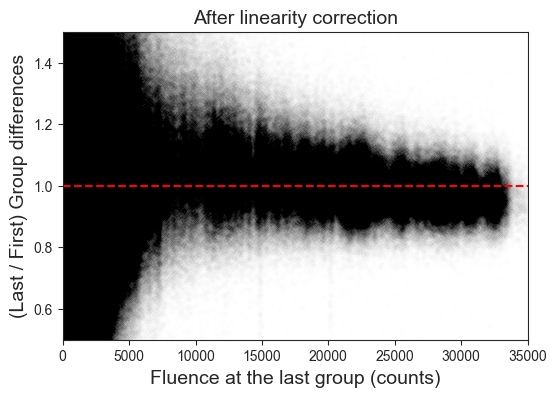

In [65]:
plt.figure(figsize = (6,4))
plt.plot(flattened_corrected_fluences, flattened_corrected_ratio, '.', alpha = 0.005, color = 'black')
plt.plot([0,35000], [1., 1.], 'r--')
plt.ylim(0.5,1.5)
plt.xlim(0,35000)
plt.xlabel('Fluence at the last group (counts)', fontsize = 14)
plt.ylabel('(Last / First) Group differences', fontsize = 14)
plt.title('After linearity correction', fontsize = 14)

plt.show()

That looks **much** better. Note, however, that as discussed above the corrections are *not* perfect. In particular, below about 20,000 counts it seems the correction makes the last group difference to be slightly larger than the first group differences; this changes for the larger fluences, where the last group difference seems to have a _smaller_ flux than the first group differences. This is actually consistent with a _charge migration_ hypothesis, on which pixels that receive larger fluences _lose_ charge to neighboring pixels that receive them. Testing this hypothesis is, of course, outside of the present Notebook --- but this showcases that plots like the ones above are fundamental to make sense of data and the overall accuracy and precision of non-linearity corrections.

Before moving to the next step, we apply the `linearity` step to all our data:

In [66]:
nsegments = 3
for i in range(nsegments):

    # Apply the linearity step to NRS1:
    uncal_nrs1[i] = calwebb_detector1.linearity_step.LinearityStep.call(uncal_nrs1[i])
    
    # Same, for NRS2:
    uncal_nrs2[i] = calwebb_detector1.linearity_step.LinearityStep.call(uncal_nrs2[i])

2023-12-02 20:23:21,370 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-12-02 20:23:21,449 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 20:23:21,450 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-12-02 20:23:21,465 - stpipe.LinearityStep - INFO - Using Linearity reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits
2023-12-02 20:23:21,491 - stpipe.LinearityStep - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored
2023-12-02 20:23:28,387 - stpipe.LinearityStep - INFO - Results used CRDS conte

### 3.5<font color='white'>-</font>Removing the dark current <a class="anchor" id="darkcurrent"></a>

One of the last steps before the most computationally expensive steps in the pipeline is the `dark_current` step. This step grabs a reference file that calculates the dark current at each group, and applies the same correction to every integration in the same way. 

It is unclear if this step is helpful at all for TSOs, where signals are typically high (and thus, the dark current is but a very small addition to the total current gathered in a TSO), but we go ahead and apply this step nonetheless in our data. First, to check what changes this step does in our data, we apply it on the first NRS1 segment: 

In [67]:
# Run the darkcurrent step:
darkcurrent_results = calwebb_detector1.dark_current_step.DarkCurrentStep.call(uncal_nrs1[0])

2023-12-02 20:24:38,888 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2023-12-02 20:24:38,970 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 20:24:38,971 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2023-12-02 20:24:38,987 - stpipe.DarkCurrentStep - INFO - Using DARK reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0388.fits
2023-12-02 20:24:39,036 - stpipe.DarkCurrentStep - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0
2023-12-02 20:24:39,037 - stpipe.DarkCurrentStep - INFO - Dark data nints=1, ngroups=

Let's see its impact on products before the dark current correction:

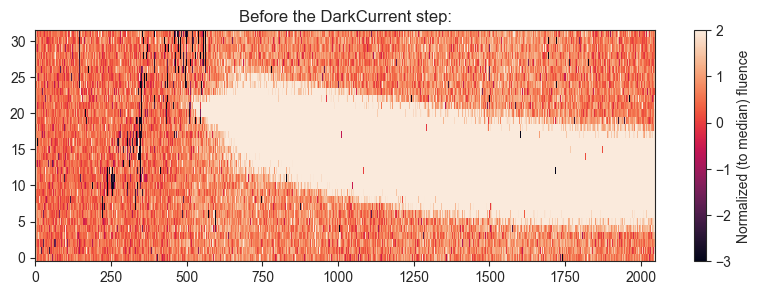

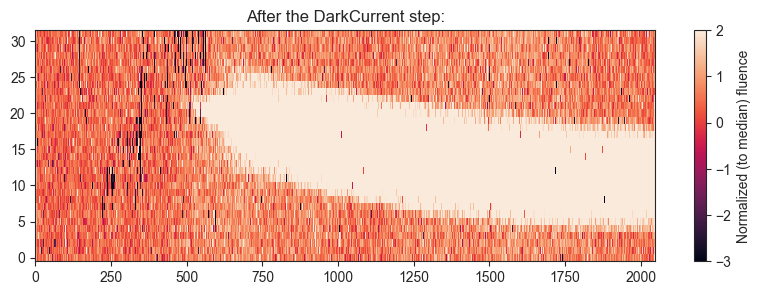

In [68]:
# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(uncal_nrs1[0].data[10,-1,:,:] / np.nanmedian(uncal_nrs1[0].data[10,-1,:,:]), \
                interpolation = 'None', aspect = 'auto', origin = 'lower')
im.set_clim(-3,2)
plt.colorbar(label = 'Normalized (to median) fluence')
plt.title('Before the DarkCurrent step:')

# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(darkcurrent_results.data[10,-1,:,:] / np.nanmedian(darkcurrent_results.data[10,-1,:,:]), \
                interpolation = 'None', aspect = 'auto', origin = 'lower')

im.set_clim(-3,2)
plt.title('After the DarkCurrent step:')
plt.colorbar(label = 'Normalized (to median) fluence')

plt.show()

Difficult to see the impact from those simple plots. 

Let's quantify "how much" dark current there is by simply calculating the average (accross integrations) percentage of dark current on the last group. The reason for doing this in the last group is that this is the group that accumulates _the most_ dark current --- as dark current grows as a function of the number of groups. 

To do this, we consider that for a non-dark current corrected signal $S_{DC}$, if we substract the dark-current corrected signal $S_{DC, corrected}$ we get the dark current signal back, i.e., $S_{DC} - S_{DC, corrected} = DC$; dividing this by the dark-current corrected signal gives us the percentage of dark current signal on each pixel. Let's calculate a map of this for all integrations and take the median of those:

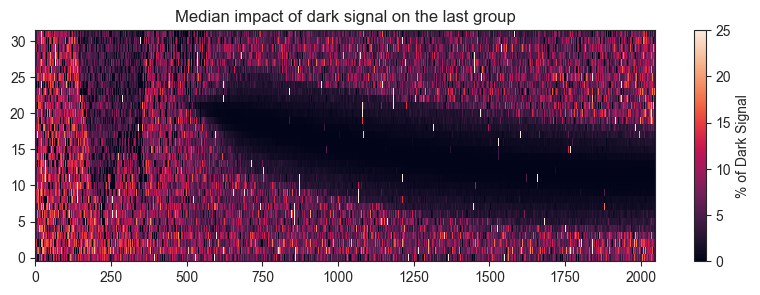

In [69]:
plt.figure(figsize=(10,3))

# Calculate the (average) percent change of the signal accross all integrations --- this is (Dark Signal) / ("Real" signal):
percent = ((linearity_results.data[:,-1,:,:] - darkcurrent_results.data[:,-1,:,:]) / 
           darkcurrent_results.data[:,-1,:,:]) * 100

percent = np.nanmedian(percent, axis = 0)

# Plot --- minimum and maximum are bounded to about 20:
im = plt.imshow(percent, \
                interpolation = 'None', aspect = 'auto', origin = 'lower')
im.set_clim(0, 25)
plt.colorbar(label = '% of Dark Signal')
plt.title('Median impact of dark signal on the last group')

plt.show()

All right, so there _is_ an impact on the order of ~10-15% for the last group, at least on the left-hand side of the detector where there is not a lot of signal --- i.e., left-most of pixel column 500. Right-most of this, it seems the impact is very low, of order ~5\% in background pixels (i.e., close to the upper and lower edges) and even lower in the location of the spectra itself --- less than ~0.03\% at the peak signal level.

How much the above impacts a given TSO must be defined on a target-by-target basis. In the worst-case scenarios, this impact might not be purely aesthetical --- this dark current can give rise to transit depth dilutions in transiting exoplanet science, for instance; just as any non-accounted background signal.

In the case of this notebook, we apply it nonetheless to all the detector-level data of both NRS1 and NRS2 in all segments, but we leave as an excercise to the reader to perform a full re-reduction with and without dark-current to see the impact of this step on this particular dataset:

In [70]:
nsegments = 3
for i in range(nsegments):

    # Apply the dark_current step to NRS1:
    uncal_nrs1[i] = calwebb_detector1.dark_current_step.DarkCurrentStep.call(uncal_nrs1[i])
    
    # Same, for NRS2:
    uncal_nrs2[i] = calwebb_detector1.dark_current_step.DarkCurrentStep.call(uncal_nrs2[i])

2023-12-02 20:24:51,304 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2023-12-02 20:24:51,401 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-12-02 20:24:51,402 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2023-12-02 20:24:51,418 - stpipe.DarkCurrentStep - INFO - Using DARK reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0388.fits
2023-12-02 20:24:51,461 - stpipe.DarkCurrentStep - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0
2023-12-02 20:24:51,462 - stpipe.DarkCurrentStep - INFO - Dark data nints=1, ngroups=


### 3.6<font color='white'>-</font>Handling 1/f noise at the group-level<a class="anchor" id="1overf"></a>

The `dark_current` step is the last in the near-infrared detectors that tries to remove any detector-level effects at the group-level, at least in the current version of the pipeline. However, some detector effects still remain --- in particular, the "infamous" [1/f noise](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources). This is a type of noise that appears on every group independently, but it _can_ be buried below some cosmetic effects if we were to plot the groups after each other --- let's showcase this by plotting the first 5 groups of the 10th integration of the NRS1 detector:

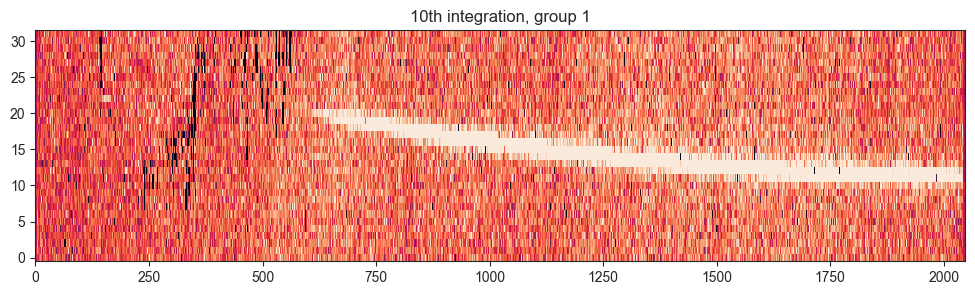

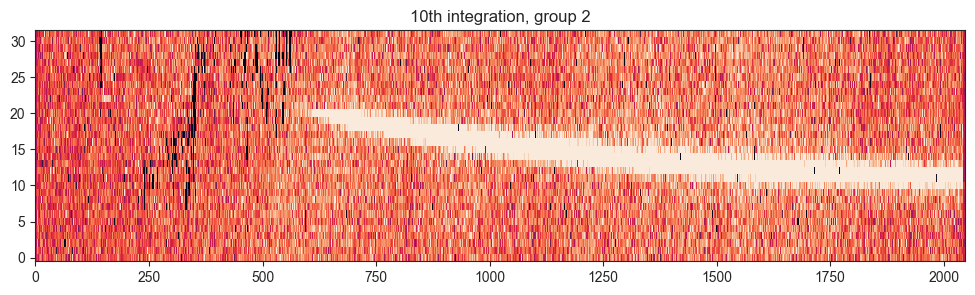

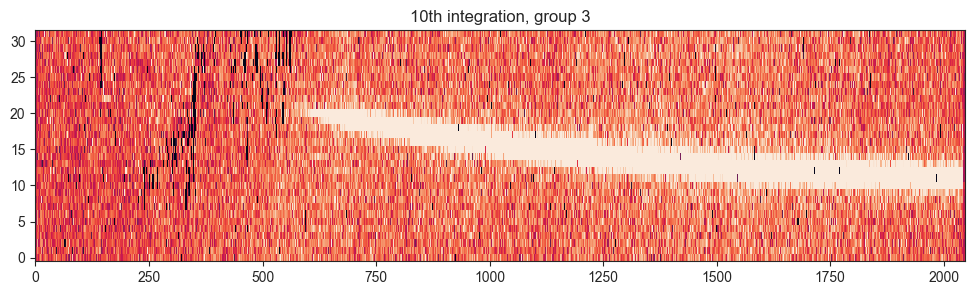

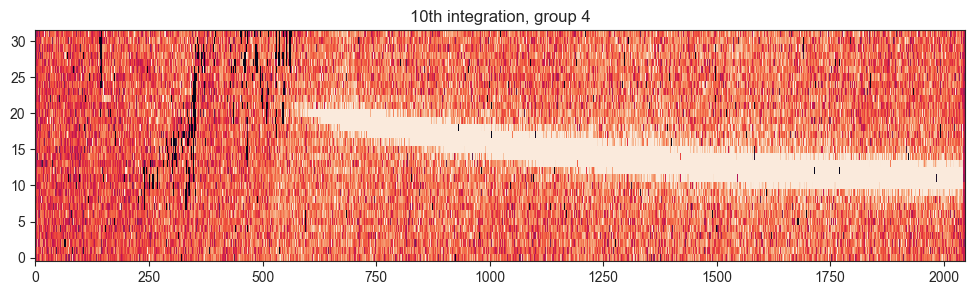

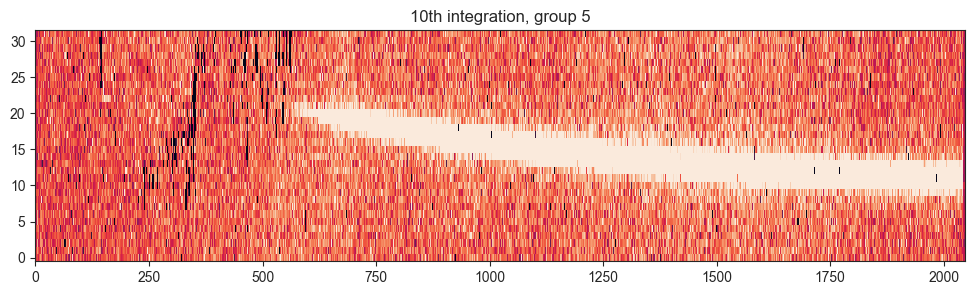

In [71]:
for i in range(5):
    
    plt.figure(figsize=(12,3))
    im = plt.imshow(uncal_nrs1[0].data[10,i,:,:], interpolation = 'None', aspect = 'auto', origin = 'lower')
    im.set_clim(-200,200)
    plt.title('10th integration, group '+str(i+1))

plt.show()

By eye, the groups appear to be more or less the same.

Instead, let's plot the differences between groups --- this should remove signals that are common to each group, and only leave any residual noise in the background region. Let's plot the differences among the first 5 groups:

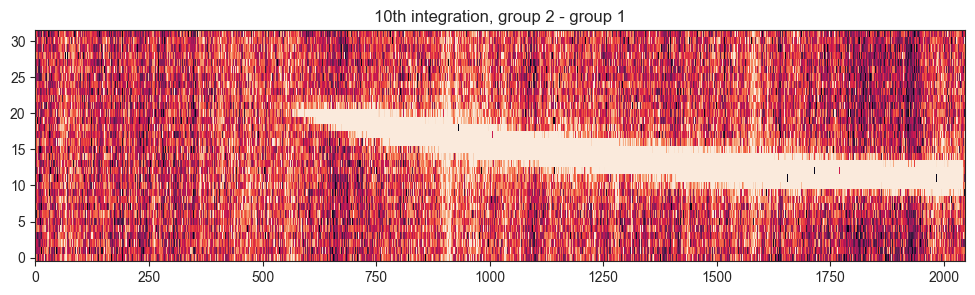

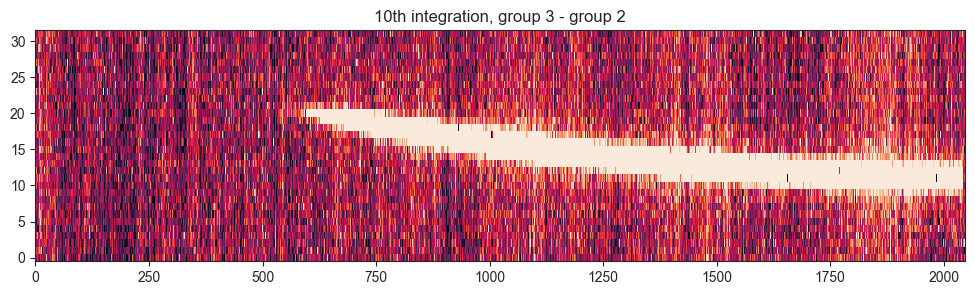

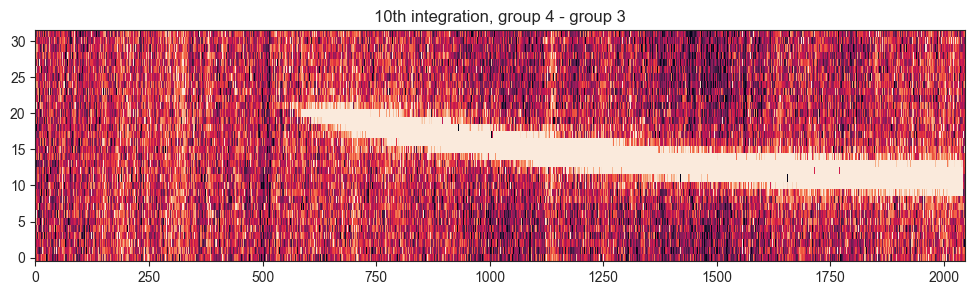

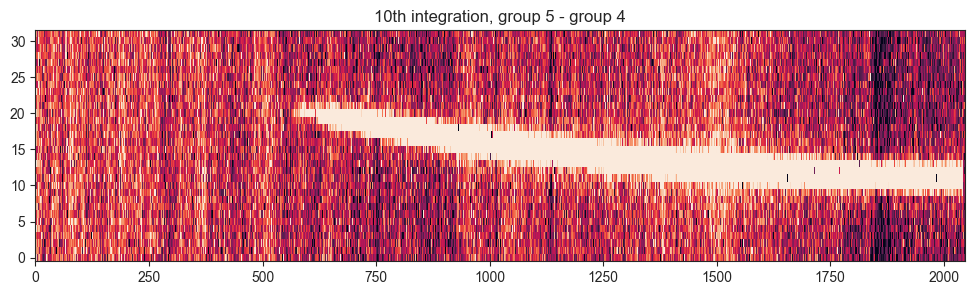

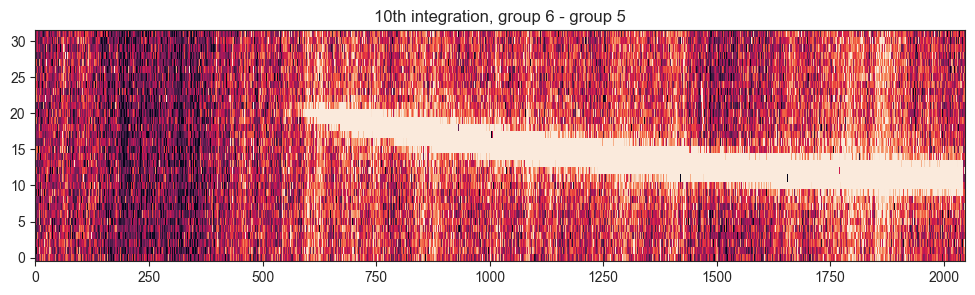

In [72]:
for i in range(5):
    
    plt.figure(figsize=(12,3))
    
    im = plt.imshow(uncal_nrs1[0].data[10,i+1,:,:] - uncal_nrs1[0].data[10,i,:,:], 
                    interpolation = 'None', aspect = 'auto', origin = 'lower')
    
    im.set_clim(-25,25)
    plt.title('10th integration, group '+str(i + 2)+' - group '+str(i+1))
    plt.show()

See those vertical stripes changing location from difference to difference? **That's a symptom of the so-called ["1/f" noise](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources)**. For a detailed description of this type of noise as seen in JWST infrared detectors, a good reference is [Schlawin et al., 2020](https://arxiv.org/abs/2010.03564). In short, the vertical stripes that are observed are, in fact, a product of a time-series that occurs _accross_ the pixels in each group (really, in each frame --- but in the case of the readout mode being used here, a frame _is_ a group). 

When pixels are read in a given up-the-ramp sample, the detector electronics read each pixel's signal sequentially. It starts with the pixel in one of the corners, and then moves to the next pixel in the same column taking, in the case of this detector (and most currently supported modes for JWST detectors), 10 microseconds. Then, it jumps to the next in the same column in 10 microseconds, and so on. When it reaches the end of a column after jumping in this case through 32 pixels, the electronics are ordered to wait 120 microseconds exactly before moving to the next column. And then the process repeats. 1/f noise in this context arises because the readout electronics have noise associated with it, and the power spectral density (PSD) of this noise, if one "tags" each pixel with the clocking process described above, has a $1/f^{\beta}$ shape --- with the power index, $\beta$, being very close to 1. 

<div class="alert alert-block alert-info"> <b>Note on 1/f as a noise source</b>: It is important to note that 1/f noise is a particularly important noise source to pay special attention in near-infrared detectors such as NIRSpec, NIRISS and NIRCam, but is not such a big piece of the puzzle in MIRI IR detectors. As such, while the discussion here could be relevant and applicable to NIR detectors, it might not be for MIRI detectors.

There's a wide array of techniques and software [from the community](https://www.stsci.edu/jwst/science-planning/tools-from-the-community) that aim at removing this 1/f noise at different stages. Here, we will try a very simple algorithm to (aim to) remove it: we will subtract background pixels on each column to the entire column, hoping this alleviates this 1/f noise. To do this, we need to follow two steps: (1) identify pixels that are "non-illuminated" in the detector, (2) remove the median of those pixels on every column for every group and integration. Let's do this next.

#### 3.6.1 Creating a background pixel mask

To create a "background pixel mask", we will here simply work with the first segment of data --- doing the same for all segments of data together is left as an exercise to the reader. The first step to generating this mask is to find a good estimate of the "median" frame --- i.e., how the median or average frame looks like. A good trick for this is to use the "last-minus-first" frames, which as the name suggests, simply removes the last group from the first to generate an estimate of the frame for a given integration. Let's do this for NRS1 and NRS2:

In [73]:
# Last-minus-first for NRS1:
lmf_nrs1 = uncal_nrs1[0].data[:, -1, :, :] - uncal_nrs1[0].data[:, 0, :, :]

# Same for NRS2:
lmf_nrs2 = uncal_nrs2[0].data[:, -1, :, :] - uncal_nrs2[0].data[:, 0, :, :]

Let's calculate the median of those, and see how they look-like:

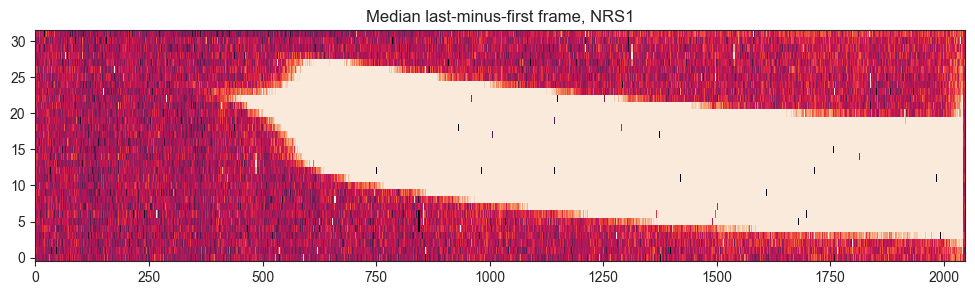

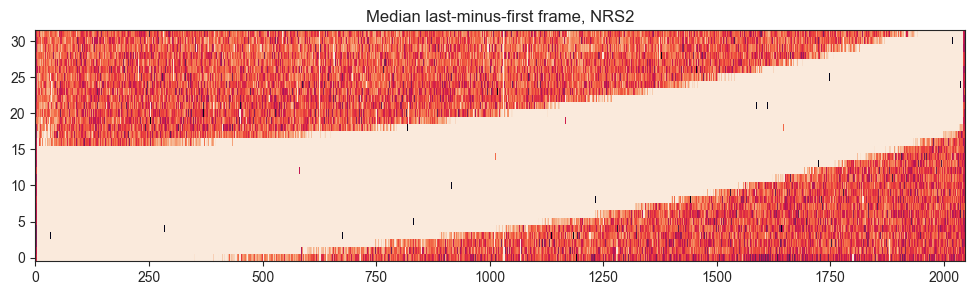

In [74]:
median_lmf_nrs1 = np.nanmedian( lmf_nrs1, axis = 0 )
median_lmf_nrs2 = np.nanmedian( lmf_nrs2, axis = 0 )

plt.figure(figsize=(12,3))
    
im = plt.imshow(median_lmf_nrs1, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-10, 10)
plt.title('Median last-minus-first frame, NRS1')
plt.show()

plt.figure(figsize=(12,3))
    
im = plt.imshow(median_lmf_nrs2, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-10, 10)
plt.title('Median last-minus-first frame, NRS2')
plt.show()

All right! These look great. Next-up, let's calculate a very simple and crude estimate of the centroid of the spectral PSF profile. To this end, let's first get a median-filtered version of this 2D image to smooth outliers out:

In [75]:
# Kernel size is 5-pixels in the rows and 11 in the columns --- roughly by eye how much pixels it takes to "jump over" outliers:
mf_median_lmf_nrs1 = medfilt2d(median_lmf_nrs1, kernel_size = (5, 11))
mf_median_lmf_nrs2 = medfilt2d(median_lmf_nrs2, kernel_size = (5, 11))

It's not very important that this median filtered version is great --- we just need for outliers to be smoothed out. Did we succeed?

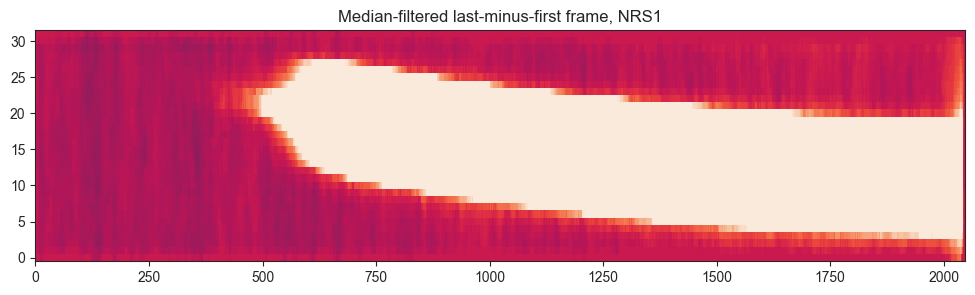

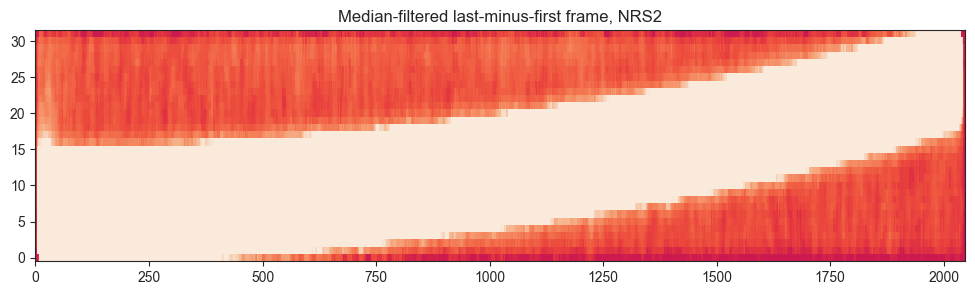

In [76]:
plt.figure(figsize=(12,3))
    
im = plt.imshow(mf_median_lmf_nrs1, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-10, 10)
plt.title('Median-filtered last-minus-first frame, NRS1')
plt.show()

plt.figure(figsize=(12,3))
    
im = plt.imshow(mf_median_lmf_nrs2, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-10, 10)
plt.title('Median-filtered last-minus-first frame, NRS2')
plt.show()

Yes! This works. Now, to simply get the centroid of each column --- we start from column 450 to 2043 in NRS1, and from pixel 4 to 2043 in NRS2. We estimate the centroids via a simple flux-weighted sum of row-positions, and then we fit those with 2nd degree polynomials. Again, our aim is not to make this perfect, but to get a "good enough" representation of the trace:

In [77]:
# Define rows for the weighted sum:
rows = np.arange(32)

# All right, calculate trace positions for NRS1:
x_nrs1 = np.arange(550, 2044, 1)
y_nrs1 = np.zeros( len(x_nrs1) )
for i in range(len(x_nrs1)):

    y_nrs1[i] = np.sum(mf_median_lmf_nrs1[:, x_nrs1[i]] * rows) / np.sum(mf_median_lmf_nrs1[:, x_nrs1[i]])

# Fit a degree 3 polynomial, extending the x-value down to 300:
coeff = np.polyfit(x_nrs1, y_nrs1, 2)
x_nrs1 = np.arange(300, 2044, 1)
y_nrs1 = np.polyval(coeff, x_nrs1)

# Now repeat for NRS2:
x_nrs2 = np.arange(4, 2044, 1)
y_nrs2 = np.zeros( len(x_nrs2) )
for i in range(len(x_nrs2)):

    y_nrs2[i] = np.sum(mf_median_lmf_nrs2[:, x_nrs2[i]] * rows) / np.sum(mf_median_lmf_nrs2[:, x_nrs2[i]])

# Fit a degree 3 polynomial:
coeff = np.polyfit(x_nrs2, y_nrs2, 2)
y_nrs2 = np.polyval(coeff, x_nrs2)
    

How did our simple algorithm do?

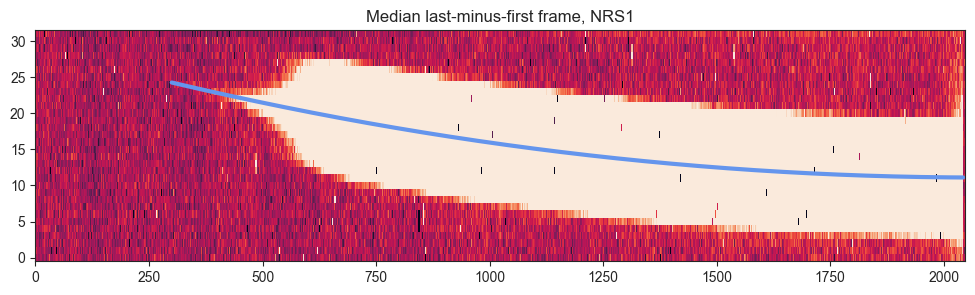

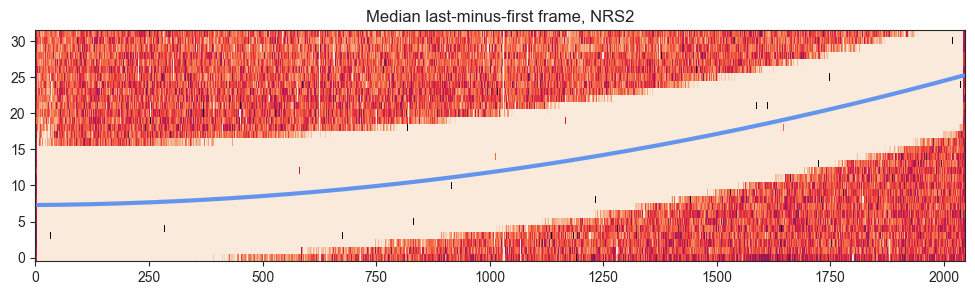

In [78]:
plt.figure(figsize=(12,3))
    
im = plt.imshow(median_lmf_nrs1, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')

plt.plot(x_nrs1, y_nrs1, '-', color = 'cornflowerblue', lw = 3)
    
im.set_clim(-10, 10)
plt.title('Median last-minus-first frame, NRS1')
plt.show()

plt.figure(figsize=(12,3))
    
im = plt.imshow(median_lmf_nrs2, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')

plt.plot(x_nrs2, y_nrs2, '-', color = 'cornflowerblue', lw = 3)
    
im.set_clim(-10, 10)
plt.title('Median last-minus-first frame, NRS2')
plt.show()

All right! These look great. 

Using these traces, we simply create a mask by masking all pixels within `r` pixels away from those traces on each column as `nan`, and all others pixels with values of `1`. The reason for this will be evident below. We will be very conservative, and take a radius `r` of 12 pixels. Let's create the masks:

In [79]:
# Define r:
r = 12 # pixels

# Create nan masks:
background_mask_nrs1 = np.ones(median_lmf_nrs1.shape)
background_mask_nrs2 = np.ones(median_lmf_nrs2.shape)

# Mark all pixels within the trace swith 1's. First for NRS1:
for i in range(len(x_nrs1)):

    lower_bound = np.max([int(y_nrs1[i]-r), 0])
    upper_bound = np.min([32, int(y_nrs1[i]+r)])
    background_mask_nrs1[lower_bound:upper_bound, x_nrs1[i]] = np.nan

# Repeat for NRS2:
for i in range(len(x_nrs2)):

    lower_bound = np.max([int(y_nrs2[i]-r), 0])
    upper_bound = np.min([32, int(y_nrs2[i]+r)])
    background_mask_nrs2[lower_bound:upper_bound, x_nrs2[i]] = np.nan

Let's see how our masks look like:

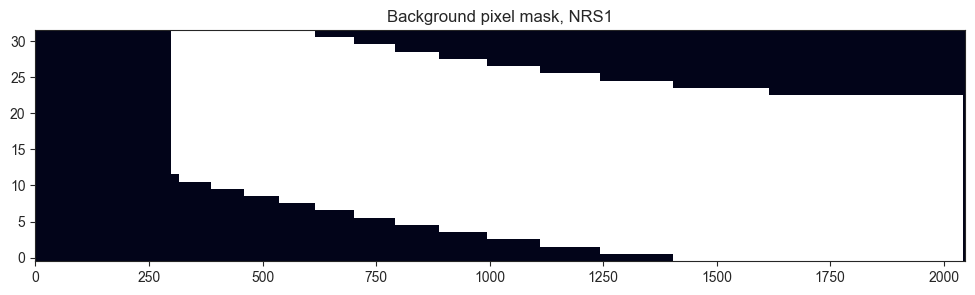

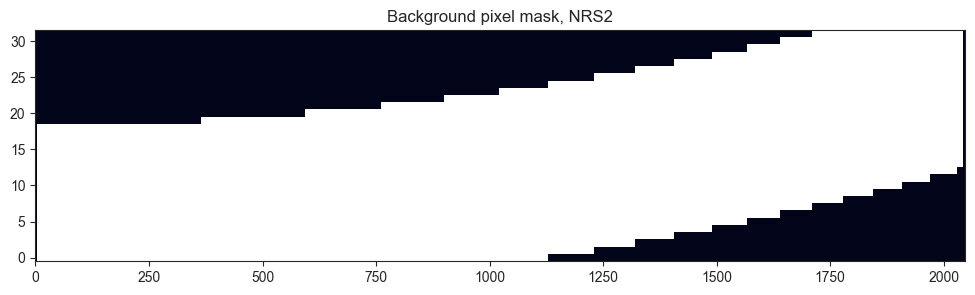

In [80]:
plt.figure(figsize=(12,3))
    
im = plt.imshow(background_mask_nrs1, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
plt.title('Background pixel mask, NRS1')
plt.show()

plt.figure(figsize=(12,3))
    
im = plt.imshow(background_mask_nrs2, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')

plt.title('Background pixel mask, NRS2')
plt.show()

Excellent! Let's use those masks to handle 1/f noise next.

#### 3.6.2 Removing 1/f noise at the group-level

Let's now use the mask generated above to remove 1/f noise with the "column-to-column" subtraction algorithm described above. To this end, we simply iterate through all integrations and all groups, multiply this `nan` mask to the data, compute the nan-median (i.e., the median using only non-nan pixels --- this is why we created a `nan` mask in the first place!) of each column --- and then remove this value from each column. 

Let's pack this idea in a function:

In [81]:
def group_level_1f_correction(input, nanmask):

    # Generate median of all columns using the nanmask:
    median_per_column = np.nanmedian( input * nanmask, axis = 0)

    # Return input minus this median per column values:
    return input - median_per_column

Now, let's do this correction on an example integration and pair of groups to see how well this works:

In [82]:
nrs1_corrected_group1 = group_level_1f_correction(uncal_nrs1[0].data[10, 0, :, :], background_mask_nrs1)
nrs1_corrected_group2 = group_level_1f_correction(uncal_nrs1[0].data[10, 1, :, :], background_mask_nrs1)

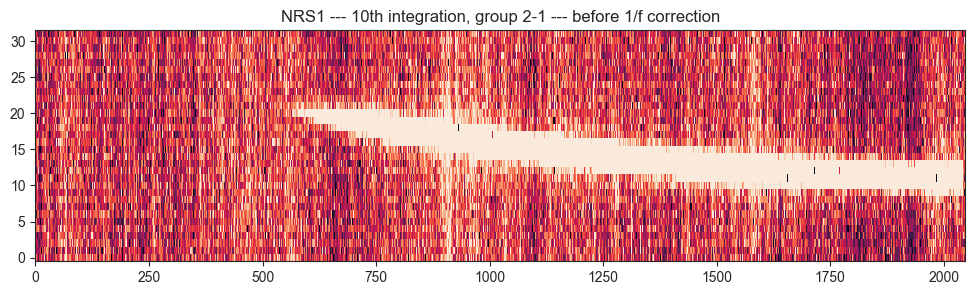

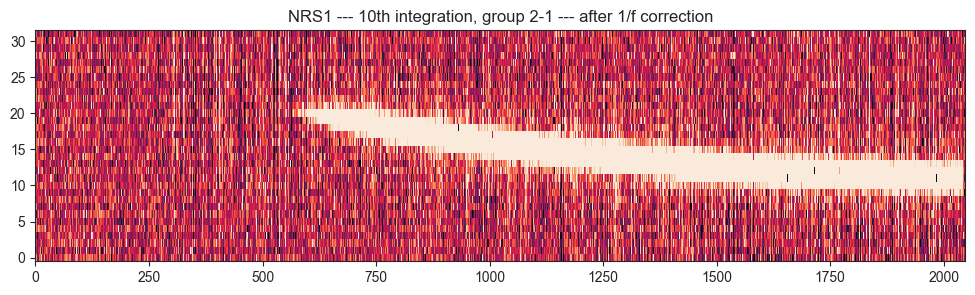

In [83]:
plt.figure(figsize=(12,3))
    
im = plt.imshow(uncal_nrs1[0].data[10, 1, :, :] - uncal_nrs1[0].data[10, 0, :, :], 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-25,25)
plt.title('NRS1 --- 10th integration, group 2-1 --- before 1/f correction')
plt.show()

plt.figure(figsize=(12,3))
    
im = plt.imshow(nrs1_corrected_group2 - nrs1_corrected_group1, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-25,25)
plt.title('NRS1 --- 10th integration, group 2-1 --- after 1/f correction')
plt.show()

Nice! How about doing it on NRS2?

In [84]:
nrs2_corrected_group1 = group_level_1f_correction(uncal_nrs2[0].data[10, 0, :, :], background_mask_nrs2)
nrs2_corrected_group2 = group_level_1f_correction(uncal_nrs2[0].data[10, 1, :, :], background_mask_nrs2)

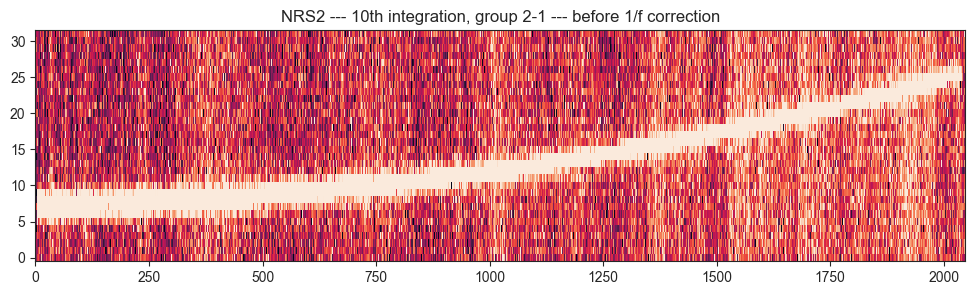

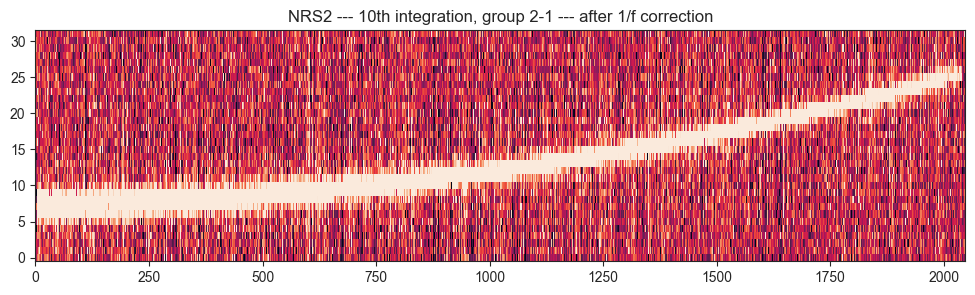

In [85]:
plt.figure(figsize=(12,3))
    
im = plt.imshow(uncal_nrs2[0].data[10, 1, :, :] - uncal_nrs2[0].data[10, 0, :, :], 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-25,25)
plt.title('NRS2 --- 10th integration, group 2-1 --- before 1/f correction')
plt.show()

plt.figure(figsize=(12,3))
    
im = plt.imshow(nrs2_corrected_group2 - nrs2_corrected_group1, 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-25,25)
plt.title('NRS2 --- 10th integration, group 2-1 --- after 1/f correction')
plt.show()

Very nice! Noticeable 1/f-noise reduction using a very simple algorithm. Let's now apply it to all integrations, all groups:

In [86]:
nsegments = 3
for i in range(nsegments):

    # Apply 1/f corrections to all integrations and groups in the segment for NRS1:
    for integration in range(uncal_nrs1[i].shape[0]):

        for group in range(uncal_nrs1[i].shape[1]):
            
            uncal_nrs1[i].data[integration, group, :, :] = group_level_1f_correction(uncal_nrs1[i].data[integration, group, :, :], 
                                                                                     background_mask_nrs1
                                                                                    )
    
    # Same, for NRS2:
    for integration in range(uncal_nrs2[i].shape[0]):

        for group in range(uncal_nrs2[i].shape[1]):
            
            uncal_nrs2[i].data[integration, group, :, :] = group_level_1f_correction(uncal_nrs2[i].data[integration, group, :, :], 
                                                                                     background_mask_nrs2
                                                                                    )

<div class="alert alert-block alert-info"> <b>Note on 1/f correction methods</b>: For TSOs, there is some discussion in the literature about whether attempting to remove 1/f noise at the group-level, at the rate-level (i.e., after all the steps in <code>detector1</code>) or both is the way to go --- and whether simplistic algorithms like the one above are optimal. The reality is that, at the time of writing, the jury is still out on the final answer. We thus encourage readers to try different methodologies and find the one that works best for their scientific use-case. As a start, an interesting reader might, e.g., skip the above 1/f removal algorithm and simply try to remove it at the rate-level --- or perform no removal at all, and see differences in the final lightcurve precision.

### 3.7<font color='white'>-</font>Detecting "jumps" in up-the-ramp samples <a class="anchor" id="jump"></a>

When a cosmic-ray hits JWST detectors, this impacts the up-the-ramp samples by making them "[jump](https://www.youtube.com/watch?v=SwYN7mTi6HM)" from one group to another. We already noted this happening above 
[when we discussed saturation](#saturation) --- a pixel was suddenly pushed above the saturation limit and the `saturation` step flagged the pixel. However, some other jumps are not as dramatic, and the data after the jump might actually be as usable as data before the jump.


#### 3.7.1 Understanding jumps and the `jump` step

To exemplify the behavior of the jumps in up-the-ramp samples, let's look at an example. Consider the behavior of pixel index `(12,1000)` in integration `67`:

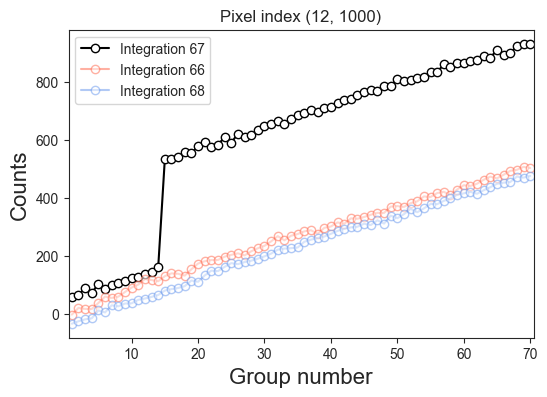

In [87]:
plt.figure(figsize=(6,4))

plt.title('Pixel index (12, 1000)')

group = np.arange(uncal_nrs1[0].data.shape[1])
plt.plot( group+1, uncal_nrs1[0].data[67, :, 12, 1000], 'o-', color = 'black', mfc = 'white', label = 'Integration 67')
plt.plot( group+1, uncal_nrs1[0].data[66, :, 12, 1000], 'o-', 
          color = 'tomato', mfc = 'white', label = 'Integration 66', alpha = 0.5)
plt.plot( group+1, uncal_nrs1[0].data[68, :, 12, 1000], 'o-', 
          color = 'cornflowerblue', mfc = 'white', label = 'Integration 68', alpha = 0.5)

plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.legend()
plt.xlim(0.5, 70.5)

plt.show()

While the intercept of the different up-the-ramp samples is slightly different, the _slope_ (i.e., the count-rate) of it is fairly similar for integrations 66, 67 and 68. However, integration 67 shows a clear jump at group 15, likely from a cosmic ray. Let's take a look at what happened in this integration and group in the 2D spectrum:

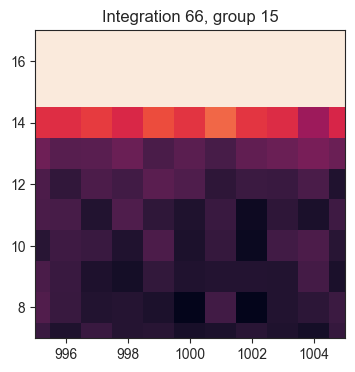

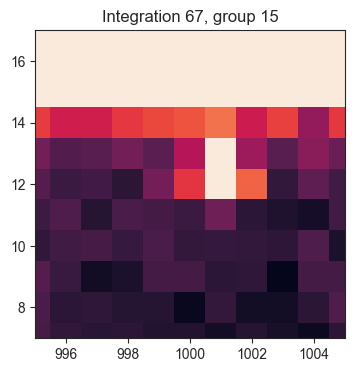

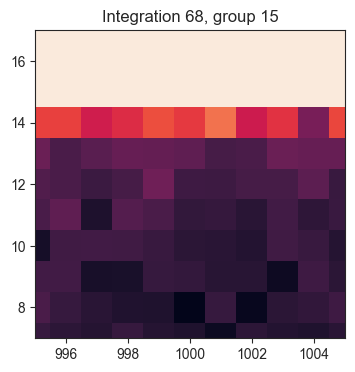

In [88]:
plt.figure(figsize=(4,4))
    
im = plt.imshow(uncal_nrs1[0].data[66,14,:,:], 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-100,1000)
plt.xlim(1000-5,1000+5)
plt.ylim(12-5,12+5)
plt.title('Integration 66, group 15')
plt.show()

plt.figure(figsize=(4,4))
    
im = plt.imshow(uncal_nrs1[0].data[67,14,:,:], 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-100,1000)
plt.xlim(1000-5,1000+5)
plt.ylim(12-5,12+5)
plt.title('Integration 67, group 15')
plt.show()

plt.figure(figsize=(4,4))
    
im = plt.imshow(uncal_nrs1[0].data[68,14,:,:], 
                interpolation = 'None', aspect = 'auto', origin = 'lower')
    
im.set_clim(-100,1000)
plt.xlim(1000-5,1000+5)
plt.ylim(12-5,12+5)
plt.title('Integration 68, group 15')
plt.show()

Ah! Clearly some cosmic ray hitting around pixel `(12,1001)`, with an area of about a pixel --- including pixel `(12,1000)`. Note that the `groupdq` doesn't show anything unusual so far:

In [89]:
uncal_nrs1[0].groupdq[67, 14, 12, 1000]

0

The JWST Calibration pipeline has an algorithm that aims to detect those jumps --- and is appropriately named the `jump` step. An important consideration when running the `jump` step is that one can use multiprocessing to run the step. This can offer dramatic speed improvements when running the step, in particular on large subarrays of data. The number of cores to use can be defined by the `maximum_cores` parameter, which can be an integer number or `all`, which will use all available cores. 

Let's run the step using all cores (if not already ran):

In [90]:
nsegments = 3

for i in range(nsegments):

    if not os.path.exists('NRS2_jumpstep_seg003.fits'):

        # Apply the jump step to NRS1:
        uncal_nrs1[i] = calwebb_detector1.jump_step.JumpStep.call(uncal_nrs1[i], maximum_cores = 'all')
    
        # Same, for NRS2:
        uncal_nrs2[i] = calwebb_detector1.jump_step.JumpStep.call(uncal_nrs2[i], maximum_cores = 'all')

    else:

        # Load NRS1 jump-step products:
        uncal_nrs1[i] = datamodels.RampModel('NRS1_jumpstep_seg00'+str(i+1)+'.fits')
    
        # Same, for NRS2:
        uncal_nrs2[i] = datamodels.RampModel('NRS2_jumpstep_seg00'+str(i+1)+'.fits')
        

It's not too obvious from the messages in the pipeline what happened, but the algorithm was used to _detect_ jumps, and these are added as new data-quality flags in the `groupdq`. Let's see what happened with the pixel identified by eye above:

In [91]:
uncal_nrs1[0].groupdq[67, 14, 12, 1000]

4

Aha! It changed. What does this mean? Let's repeat the trick we learned with the `saturation` step:

In [92]:
datamodels.dqflags.dqflags_to_mnemonics(uncal_nrs1[0].groupdq[67, 14, 12, 1000], 
                                        mnemonic_map = datamodels.dqflags.pixel)

{'JUMP_DET'}

Nice! We now have a flag that identifies when a jump detection happened. 

#### 3.7.2 Jump rates per integration

For fun, let's use the `groupdq` changes to figure out how many jumps happened per integration on this first segment of data by simple differencing with the products from the previous step, the `dark_current` step:

In [93]:
# Create an array that will store the number of jumps per integration:
njumps = np.zeros(uncal_nrs1[0].groupdq.shape[0])

# Iterate through integrations counting how many pixels changed in all groups:
for integration in range(uncal_nrs1[0].groupdq.shape[0]):

    groupdq_difference = uncal_nrs1[0].groupdq[integration, :, :, :] - darkcurrent_results.groupdq[integration, :, :, :]
    wherejumps = np.where(groupdq_difference != 0.)
    njumps[integration] = len(wherejumps[0])

Let's plot this:

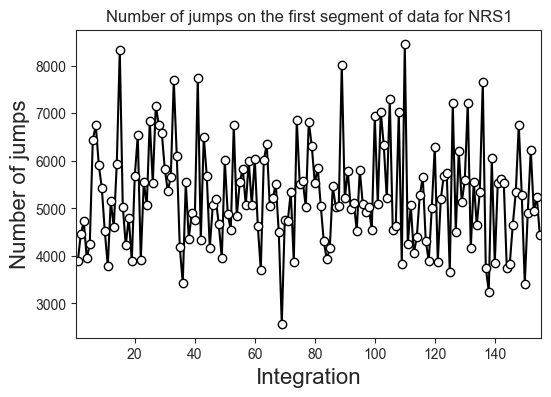

In [94]:
plt.figure(figsize=(6,4))

plt.title('Number of jumps on the first segment of data for NRS1')

integrations = np.arange(uncal_nrs1[0].groupdq.shape[0]) + 1
plt.plot( integrations, njumps, 'o-', color = 'black', mfc = 'white' )

plt.xlabel('Integration', fontsize = 16)
plt.ylabel('Number of jumps', fontsize = 16)
plt.xlim(0.5, uncal_nrs1[0].groupdq.shape[0] + 0.5)

plt.show()

Very interesting! Per integration, it seems on the order of ~5,000 average jumps are detected. Each integration has (ngroups) x (number of pixels) =  70 x 32 x 2048 = 4587520 opportunities for jumps to appear, so this means an average rate of (detected events) / (total opportunities) = 0.11% per integration for this particular segment, detector and dataset.

<div class="alert alert-block alert-info"> <b>Note on the effectiveness of the <code>jump</code> detection step</b>: The <code>jump</code> detection step uses, by default, <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/description.html#multiprocessing">a two-point difference method</a> that relies on appropriate knowledge of the read-noise of the detector. In some cases, this might be significantly off (or <code>detector1</code> corrections might not be optimal as to leave significant detector effects) such that the algorithm might be shown to be too aggressive. Similarly, the algorithm relies on a decent amount of groups in the integration to work properly (larger than about 5). It is, thus, important to try different parameters to identify jumps in a given dataset and study their impact on the final products. One of the most important parameters is the <code>rejection_threshold</code>. The default value is <code>4</code>, but TSO studies in the literature have sometimes opted for more conservative values (typically larger than 10). For this particular dataset, which has a large number of groups (70), the default value works well, but it might not be optimal nor be the best for other datasets.

Before moving to the next step, we showcase one additional function from the `datamodels` which allows to save products to files --- the `save` function. We use it to save our `jump` step products for later use:

In [95]:
if not os.path.exists('NRS2_jumpstep_seg003.fits'):
    
    nsegments = 3

    for i in range(nsegments):

        # Save jump step NRS1 products:
        uncal_nrs1[i].save('NRS1_jumpstep_seg00'+str(i+1)+'.fits')
    
        # Same, for NRS2:
        uncal_nrs2[i].save('NRS2_jumpstep_seg00'+str(i+1)+'.fits')

### 3.8<font color='white'>-</font>Fitting ramps with the `ramp_fit` step <a class="anchor" id="rampfit"></a>

The last step of `detector1` is the `ramp_fit` step. This step does something that might _appear_ to be quite simple, but that in reality it's not as trivial as it seems to be: fit a line and get the associated uncertainties to the up-the-ramp samples. The reason why this is not straightforward to do is because samples up-the-ramp are correlated. That is, because signal is accumulated up-the-ramp, group number 2 has a non-zero covariance with group number 1, and so on. 

#### 3.8.1 Applying the `ramp_fit` step to JWST data

The JWST Calibration pipeline algorithm performs a sensible weighting of each group in order to account for that correlation when fitting a slope on the samples. Let's run this step, and save the products in files as we go, so we can use them for the next notebook. Note that as in the `jump` step, we can also run this step via multi-processing --- and we do just that below (if not ran already):

In [96]:
nsegments = 3
ramps_nrs1 = []
ramps_nrs2 = []

for i in range(nsegments):

    if not os.path.exists('NRS2_jumpstep_seg003_1_rampfitstep.fits'):
        
        # Apply the rampfit step to NRS1:
        ramps_nrs1.append( calwebb_detector1.ramp_fit_step.RampFitStep.call(uncal_nrs1[i], 
                                                                            maximum_cores = 'all', 
                                                                            save_results=True)
                         )
    
        # Same, for NRS2:
        ramps_nrs2.append( calwebb_detector1.ramp_fit_step.RampFitStep.call(uncal_nrs2[i], 
                                                                            maximum_cores = 'all',
                                                                            save_results=True) 
                         )

    else:

        ramps_nrs1.append( [ datamodels.open('NRS1_jumpstep_seg00'+str(i+1)+'_0_rampfitstep.fits'), 
                             datamodels.open('NRS1_jumpstep_seg00'+str(i+1)+'_1_rampfitstep.fits')
                           ] 
                         )

        ramps_nrs2.append( [ datamodels.open('NRS2_jumpstep_seg00'+str(i+1)+'_0_rampfitstep.fits'), 
                             datamodels.open('NRS2_jumpstep_seg00'+str(i+1)+'_1_rampfitstep.fits')
                           ] 
                         )

All right! First of all, note the products of this step for TSO's are actually a list:

In [97]:
len(ramps_nrs1[0])

2

The data associated with the zeroth element of this list (`ramps_nrs1[0][0].data`) has dimensions equal to the size of the frames (rows and columns). The first element (`ramps_nrs1[0][1].data`), has three dimensions, the same as the zeroth but for each integration. We usually refer to this latter product as the `rateints` product --- i.e., the rates per integration:

In [98]:
ramps_nrs1[0][0].data.shape

(32, 2048)

In [99]:
ramps_nrs1[0][1].data.shape

(155, 32, 2048)

To familiarize ourselves with these products, let's plot the rates of the 10th integration for NRS1:

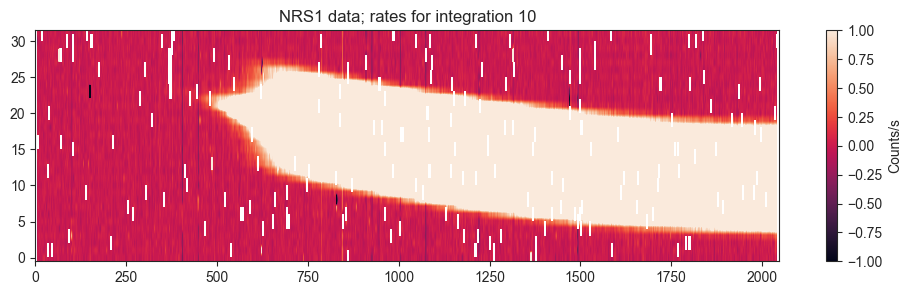

In [100]:
plt.figure(figsize=(12,3))

plt.title('NRS1 data; rates for integration 10')
im = plt.imshow(ramps_nrs1[0][1].data[10, :, :], aspect = 'auto', origin = 'lower')
im.set_clim(-1,1)

plt.colorbar(label = 'Counts/s')

In case you were unsure of the units in the colorbar, you can double-check them through the `datamodels` themselves:

In [101]:
ramps_nrs1[0][1].search('unit')

root (AsdfObject)
└─meta (dict)
  ├─bunit_data (str): DN/s
  ├─bunit_err (str): DN/s
  └─time_unit (str): s

These rates look very pretty! What about the same for NRS2?

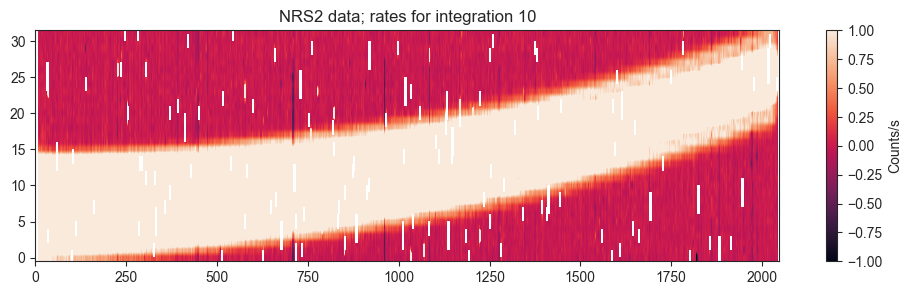

In [102]:
plt.figure(figsize=(12,3))

plt.title('NRS2 data; rates for integration 10')
im = plt.imshow(ramps_nrs2[0][1].data[10, :, :], aspect = 'auto', origin = 'lower')
im.set_clim(-1,1)

plt.colorbar(label = 'Counts/s')

These rates look _very_ good. 


#### 3.8.2 Linking rates and up-the-ramp samples

Do these rates match the slopes observed on real up-the-ramp samples? Let's check integration 68 of pixel (`12,1000`), which we already encountered above when we studied the `jump`-step. 

We first need to figure out the group-time, as the rates are in counts per second. This is easy to obtain from the `datamodels` themselves:

In [103]:
ramps_nrs1[0][1].search('group_time')

root (AsdfObject)
└─meta (dict)
  └─exposure (dict)
    └─group_time (float): 0.902

All right! Group-time is 0.902 seconds. With this, let's plot the up-the-ramp samples, and the slope on top estimated by the ramp-fitting algorithm along with the _error_ on the ramp, which can be obtained from the `err` array in the `datamodel` for the rates:

2023-12-02 20:28:53,034 - stpipe - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


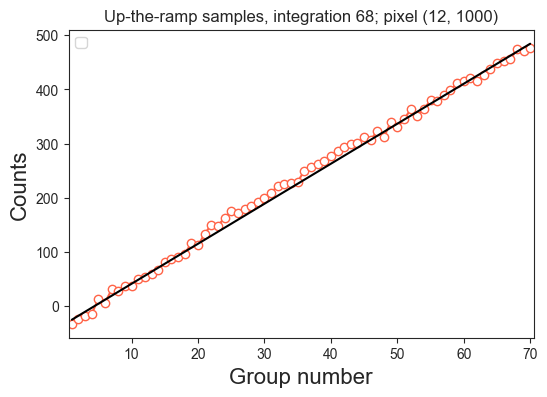

In [104]:
plt.figure(figsize=(6,4))

plt.title('Up-the-ramp samples, integration 68; pixel (12, 1000)')

group = np.arange(uncal_nrs1[0].data.shape[1])
plt.plot( group+1, uncal_nrs1[0].data[68, :, 12, 1000], 'o-', 
          color = 'tomato', mfc = 'white')

slope = ramps_nrs1[0][1].data[68, 12, 1000] # In counts per second
group_time = ramps_nrs1[0][1].meta.exposure.group_time # Group time in seconds

# Estimate rate up-the-ramp:
plt.plot( group+1, uncal_nrs1[0].data[68, :, 12, 1000][0] + (group+1) * group_time * slope, color = 'black')

plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.legend()
plt.xlim(0.5, 70.5)

plt.show()

That looks pretty good!

#### 3.8.3 Crude rate-based white-light lightcurves

Before ending this notebook, let's get a very quick, crude, lightcurve from NRS1 and NRS2, so we can see that the transit event is actually in our data. To this end, let's first stitch all ramps together in a single array for NRS1 and NRS2:

In [105]:
nrs1_rateints = np.vstack(( ramps_nrs1[0][1].data, ramps_nrs1[1][1].data ))
nrs1_rateints = np.vstack(( nrs1_rateints, ramps_nrs1[2][1].data ))

nrs2_rateints = np.vstack(( ramps_nrs2[0][1].data, ramps_nrs2[1][1].data ))
nrs2_rateints = np.vstack(( nrs2_rateints, ramps_nrs2[2][1].data ))

And now let's get the sum accross the detector for the rateint products:

In [106]:
lc_nrs1 = np.nansum( nrs1_rateints, axis = (1,2) )
lc_nrs2 = np.nansum( nrs2_rateints, axis = (1,2) )

Let's now plot some crude, normalized lightcurves:

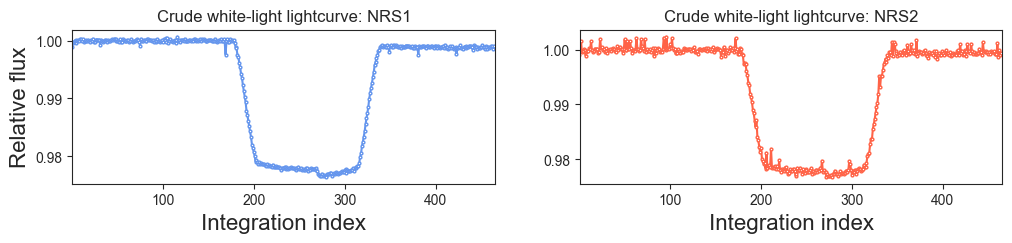

In [107]:
plt.figure(figsize=(12,2))

plt.subplot(121)
plt.title('Crude white-light lightcurve: NRS1')

plt.plot( lc_nrs1 / np.nanmedian(lc_nrs1[:100]), 'o-', 
          color = 'cornflowerblue', mfc = 'white', ms = 2)


plt.xlabel('Integration index', fontsize = 16)
plt.ylabel('Relative flux', fontsize = 16)
plt.xlim(0.5, len(lc_nrs1)+0.5)

plt.subplot(122)
plt.title('Crude white-light lightcurve: NRS2')

plt.plot( lc_nrs2 / np.nanmedian(lc_nrs2[:100]), 'o-', 
          color = 'tomato', mfc = 'white', ms = 2)

plt.xlabel('Integration index', fontsize = 16)
plt.xlim(0.5, len(lc_nrs1)+0.5)

plt.show()

Et voilà! This is by all means a very crude white-light lightcurve, but this does showcase that our processing is in the right direction. The proper spectroscopic extraction and lightcurve generation will be done in the companion notebook!

4.<font color='white'>-</font>Final words <a class="anchor" id="final-words"></a>
------------------

It is important to note that the JWST pipeline as it is right now will and currently is changing as we learn more about on-sky data. The number of people behind this effort is large, and as such I would like to take the opportunity to thank the entire JWST team behind this notebook, that through testing (with actual detector data, through simulations, etc.) and discussions made this product possible. 

For this particular effort of writing the notebook, I would like to thank the JWST Time-Series Observations Working Group at STScI, especially to Mike Reagan, Stephan Birkmann, Nikolay Nikolov, Arpita Roy, Loïc Albert and Leonardo Ubeda among others. To the NIRCam IDT members, including Everett Schlawin, Jarron Leisenring, Thomas Greene and Thomas Beatty with which a ton of discussion has been ongoing on different topics touched upon here. To the ERS Transiting Exoplanet team who have provided several venues for discussion and community input. To the JWST team behind the pipeline and the mission itself, including and in no particular order Anton Koekemoer, Alicia Canipe, Jeff Valenti, Karl Gordon, Bryan Hilbert and Joseph Filippazzo. 